In [1]:
try:
  import google.colab
  RUNNING_ON_COLAB= True
except:
  RUNNING_ON_COLAB= False

if RUNNING_ON_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [2]:
!ls

 Combine_Features.ipynb		'kNN - standard scaler.ipynb'
 data				 mlruns
'EDA - kNN (3)  .ipynb'		 models
 experimentation.ipynb		 plots
 exploration_basic.ipynb	 Random_forest_confusion_matrix.png
 Feature_eng.ipynb		 screenshots
'kNN - MinMaxScaler.ipynb'	 svm_13.01.ipynb
'kNN - no preprocessing.ipynb'	 SVM_model.ipynb


In [3]:
import os 

In [4]:
USER = os.environ.get('USER')
print(f'Current user: {USER}')

Current user: hdd_n


In [5]:
PATH = 'data/diabetes_012_health_indicators_BRFSS2015.csv'

In [6]:
#from sklearnex import patch_sklearn

In [7]:
# patch_sklearn()

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import lightgbm
import xgboost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.utils import class_weight


import optuna
from optuna.integration import LightGBMPruningCallback

import sklearn.tree as tree
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

import time
import mlflow

In [9]:
data = pd.read_csv(PATH)

In [10]:
X, Y = data.drop("Diabetes_012", axis = 1), data['Diabetes_012'].astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

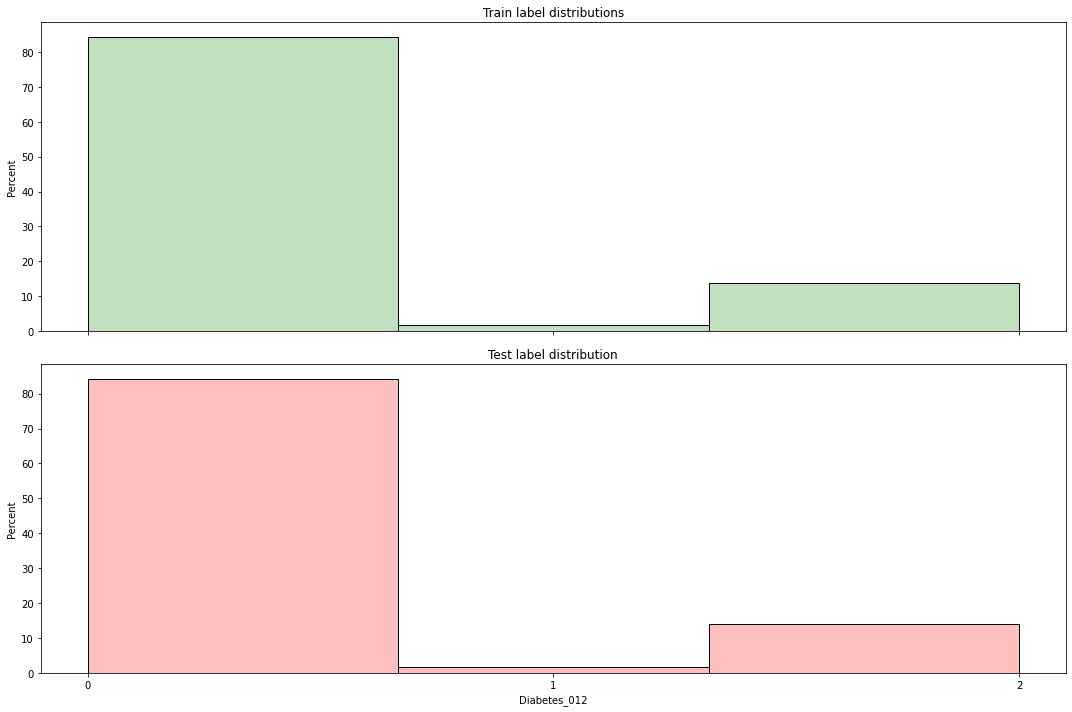

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10), sharex=True)
sns.histplot(Y_train, stat = 'percent', color = 'green', bins = 3, alpha = .25, ax = axs[0]).set_title('Train label distributions')
sns.histplot(Y_test, stat = 'percent', color = 'red', bins = 3, alpha =.25, ax = axs[1]).set_title('Test label distribution')
plt.xticks([0,1,2])
fig.tight_layout()

In [12]:
Y_train.value_counts().sort_index() /  len(Y_train)

0    0.842351
1    0.018251
2    0.139398
Name: Diabetes_012, dtype: float64

In [13]:
# class_weights = (Y_train.value_counts().sort_index()/ len(Y_train)).to_dict()
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Y_train), y = Y_train)
class_weights

array([ 0.39571805, 18.26349892,  2.39123365])

In [14]:
#client = mlflow.tracking.MlflowClient()

In [15]:
#mlflow.tracking.get_tracking_uri()

In [16]:
#mlflow.sklearn.autolog(silent = True)
#mlflow.lightgbm.autolog(silent = True)
#mlflow.xgboost.autolog()

In [14]:
def custom_logging(y_true, y_pred,  verbose = 1, save_fig = False):
    mcc = matthews_corrcoef(y_true = y_true, y_pred = y_pred)

    acc = accuracy_score(y_true = y_true, y_pred = y_pred)
    f1 = f1_score(y_true = y_true, y_pred = y_pred, average='weighted')

    mlflow.log_metric(key = 'acc_', value = acc)
    mlflow.log_metric(key = 'f1_', value = f1)
    mlflow.log_metric(key = 'mcc_', value = mcc)

    if verbose:
        print(classification_report(y_true, y_pred, target_names=['0', '1', '2']))
        
        print()
        print(f"ACC: \t{acc}")
        print(f"MCC: \t{mcc}")

        cf = confusion_matrix(y_true=y_true, y_pred = y_pred)
        print('Confusion matrix: ')
        fig, axs = plt.subplots(nrows = 2, ncols = 1, sharey = True, sharex = True)
        sns.heatmap(cf, annot = True, cmap = 'Greens', ax = axs[0], fmt = 'd')
        sns.heatmap(cf/np.sum(cf), annot = True, cmap = 'Greens', ax = axs[1], fmt = '.3g')
        for ax in axs:
            ax.set_ylabel('True labels')
        ax.set_xlabel('Predicted labels')
        
        if save_fig:
            filename = input('Please provide a name for the plot to be saved: ')
            plt.savefig('/data/'+ filename)


In [ ]:
mlflow.create_experiment('Base-models')

### Models w/ default params, no additional feature

#### Decision trees

In [18]:
# Checking the params of decision trees
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     42753
           1       0.03      0.03      0.03       927
           2       0.29      0.32      0.31      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.40      0.40     50736
weighted avg       0.78      0.77      0.77     50736


ACC: 	0.7674629454430779
MCC: 	0.18218319428518767
Confusion matrix: 


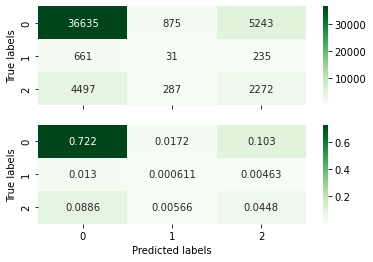

In [19]:

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_preds = decision_tree.predict(X_test)
custom_logging(Y_test, Y_preds)



              precision    recall  f1-score   support

           0       0.88      0.86      0.87     42753
           1       0.03      0.04      0.03       927
           2       0.30      0.32      0.31      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.41      0.40     50736
weighted avg       0.78      0.77      0.77     50736


ACC: 	0.7686061179438662
MCC: 	0.1843073592665669
Confusion matrix: 


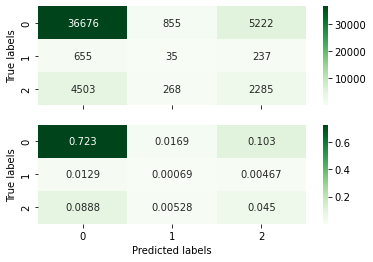

In [20]:
# sklearnex
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_preds = decision_tree.predict(X_test)
custom_logging(Y_test, Y_preds)

In [21]:
# include class_weights 
weights = np.array(Y_train.value_counts()[0] /Y_train.value_counts().sort_index().values, dtype = int)
class_weights = {
    0:weights[0],
    1:weights[1],
    2:weights[2]
}
class_weights

{0: 1, 1: 46, 2: 6}

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     42753
           1       0.03      0.03      0.03       927
           2       0.29      0.30      0.29      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.40      0.40     50736
weighted avg       0.78      0.77      0.77     50736


ACC: 	0.7667928098391674
MCC: 	0.1655654901937969
Confusion matrix: 


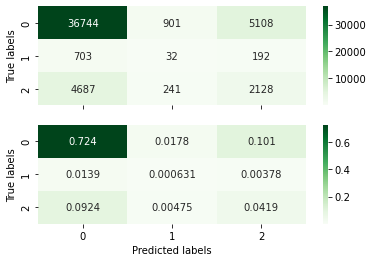

In [22]:
decision_tree = DecisionTreeClassifier(class_weight = class_weights)
decision_tree.fit(X_train, Y_train)
Y_preds = decision_tree.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     42753
           1       0.03      0.03      0.03       927
           2       0.28      0.29      0.29      7056

    accuracy                           0.77     50736
   macro avg       0.39      0.40      0.39     50736
weighted avg       0.77      0.77      0.77     50736


ACC: 	0.7655313781141596
MCC: 	0.16060759081162593
Confusion matrix: 


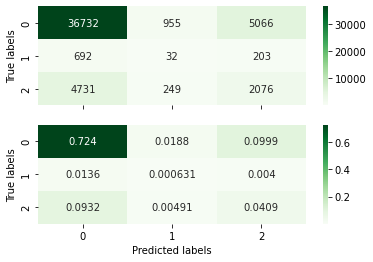

In [23]:
decision_tree = DecisionTreeClassifier(class_weight = 'balanced')
decision_tree.fit(X_train, Y_train)
Y_preds = decision_tree.predict(X_test)
custom_logging(Y_test, Y_preds)

In [24]:
# compute_class_weight = 'balanced'

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     42753
           1       0.03      0.03      0.03       927
           2       0.28      0.29      0.29      7056

    accuracy                           0.76     50736
   macro avg       0.39      0.39      0.39     50736
weighted avg       0.77      0.76      0.77     50736


ACC: 	0.7639940081993062
MCC: 	0.1567934726411928
Confusion matrix: 


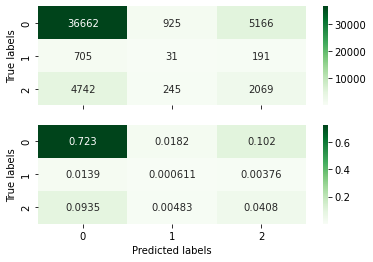

In [25]:
cw = {
    0:class_weights[0],
    1:class_weights[1],
    2:class_weights[2]
    }

decision_tree = DecisionTreeClassifier(class_weight = cw)
decision_tree.fit(X_train, Y_train)
Y_preds = decision_tree.predict(X_test)
custom_logging(Y_test, Y_preds)

The class weight param yielded no result, as the default param 

#### Random forest

In [26]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.02      0.00      0.00       927
           2       0.47      0.19      0.28      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.79      0.84      0.81     50736


ACC: 	0.8407048249763481
MCC: 	0.22669980364304435
Confusion matrix: 


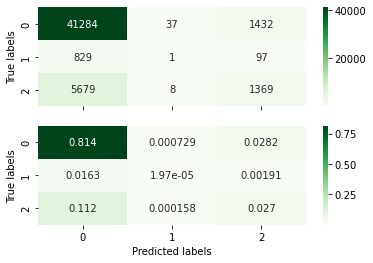

In [27]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, Y_train)
Y_preds = rf_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.03      0.00      0.00       927
           2       0.48      0.19      0.27      7056

    accuracy                           0.84     50736
   macro avg       0.46      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736


ACC: 	0.8421042257962787
MCC: 	0.23034726875349731
Confusion matrix: 


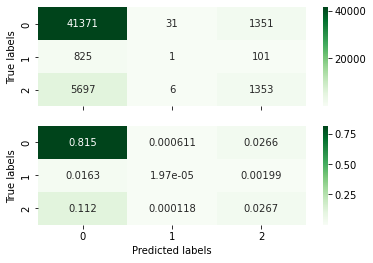

In [28]:
# with sklearnex
rf_model = RandomForestClassifier(n_estimators=1000, n_jobs = -1)
rf_model.fit(X_train, Y_train)
Y_preds = rf_model.predict(X_test)
custom_logging(Y_test, Y_preds)
plt.savefig('Random_forest_confusion_matrix')

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.01      0.00      0.00       927
           2       0.45      0.16      0.24      7056

    accuracy                           0.84     50736
   macro avg       0.44      0.38      0.38     50736
weighted avg       0.79      0.84      0.80     50736


ACC: 	0.8373344370860927
MCC: 	0.19475667555057
Confusion matrix: 


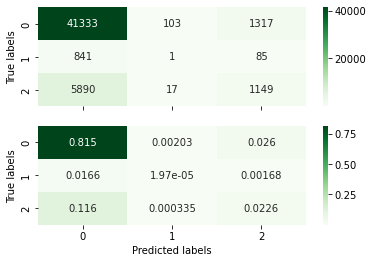

In [29]:
rf_model = RandomForestClassifier(class_weight=class_weights, n_jobs = -1)
rf_model.fit(X_train, Y_train)
Y_preds = rf_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.01      0.00      0.00       927
           2       0.46      0.16      0.23      7056

    accuracy                           0.84     50736
   macro avg       0.44      0.38      0.38     50736
weighted avg       0.79      0.84      0.80     50736


ACC: 	0.8383593503626616
MCC: 	0.193936133784075
Confusion matrix: 


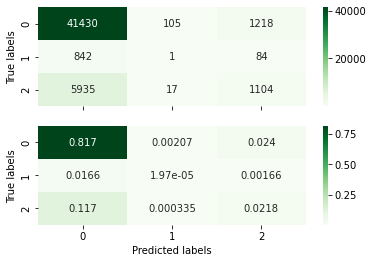

In [30]:
rf_model = RandomForestClassifier(class_weight = 'balanced', n_estimators=1000, n_jobs =-1)
rf_model.fit(X_train, Y_train)
Y_preds = rf_model.predict(X_test)
custom_logging(Y_test, Y_preds)

#### Gradient Boosting Machine

In [31]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.54      0.18      0.28      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8483719646799117
MCC: 	0.2495945390794021
Confusion matrix: 


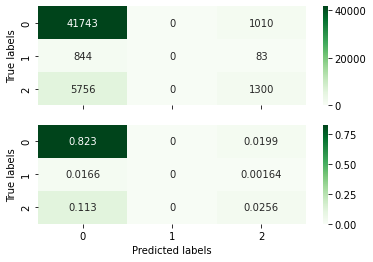

In [32]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, Y_train)
Y_preds = gbm_model.predict(X_test)
custom_logging(Y_test, Y_preds)

GBM has no parameter for class balancing, or to be more precise we weren't able to indentify parameters that could directly impact the class imbalance problem. In this case, one approach could involve oversampling the minority classes, and undersampling the majority class.

#### XGB

[20:16:11] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


ACC

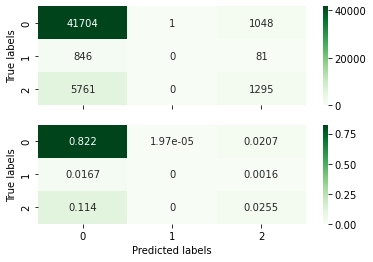

In [33]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softmax',
                use_label_encoder=False,
                num_classes = 3, 
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

In [34]:
class_weights

{0: 1, 1: 46, 2: 6}

[20:16:13] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes", "weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     

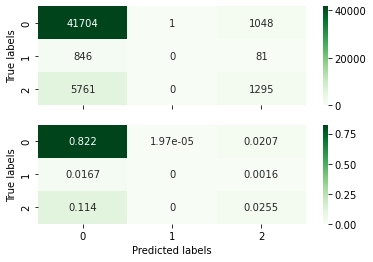

In [35]:
# handling imbalanced classes through scale_pos_weight
# spw = count(negative_examples)/ count(positive_examples)
# ad1: scale_pos_weight cannot be applied as it is not a binary classification problem...


xgb_model = xgboost.XGBClassifier(objective = 'multi:softmax',
                use_label_encoder=False,
                num_classes = 3,
                weights = class_weights,
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

In [36]:
scp = Y_train.value_counts().sort_index()[0] / (Y_train.value_counts().sort_index()[1] + Y_train.value_counts().sort_index()[2])

[20:16:14] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      

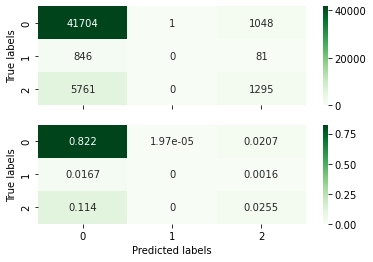

In [37]:

xgb_model = xgboost.XGBClassifier(objective = 'multi:softprob',
                use_label_encoder=False,
                num_classes = 3,
                scale_pos_weight = scp,
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

In [38]:
weights = [1,10,25, 50, 75, 100]
param_grid = dict(scale_pos_weight = weights)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:15] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      

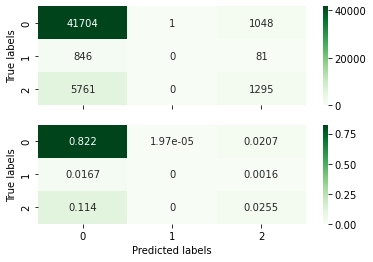

In [39]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softprob',
                num_classes = 3,
                scale_pos_weight = 10,
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:17] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      

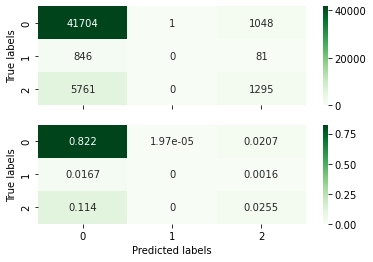

In [40]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softprob',
                num_classes = 3,
                scale_pos_weight = 25,
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:18] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      

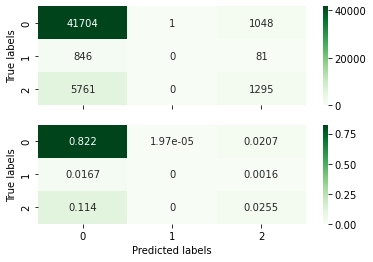

In [41]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softprob',
                num_classes = 3,
                scale_pos_weight = 50,
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

[20:16:19] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8475047303689688
MCC: 	0.245337023001692
Confusion matrix: 


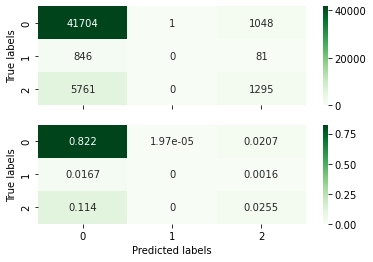

In [42]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softprob',
                num_classes = 3,
                scale_pos_weight = 75,
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

[20:16:20] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8475047303689688
MCC: 	0.245337023001692
Confusion matrix: 


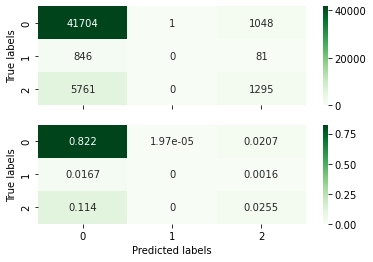

In [43]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softprob',
                num_classes = 3,
                scale_pos_weight = 100,
                tree_method = 'gpu_hist')
xgb_model.fit(X_train, Y_train)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

#### LGBM

In [18]:
lightgbm.LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8490618101545254
MCC: 	0.24923258027101233
Confusion matrix: 


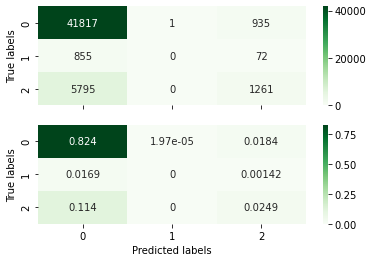

In [103]:
lgb_model = lightgbm.LGBMClassifier(objective='multiclass')
lgb_model.fit(X_train, Y_train)
Y_preds = lgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8490618101545254
MCC: 	0.24923258027101233
Confusion matrix: 


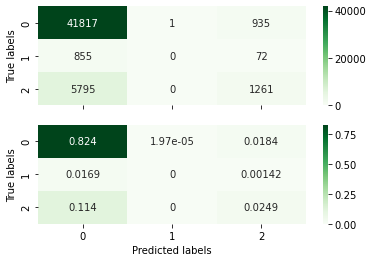

In [104]:
lgb_model = lightgbm.LGBMClassifier(objective='multiclass',
                        is_unbalance = True, 
                        num_classes = 3,
                        
                )
lgb_model.fit(X_train, Y_train)
Y_preds = lgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.95      0.67      0.79     42753
           1       0.02      0.16      0.04       927
           2       0.34      0.69      0.45      7056

    accuracy                           0.66     50736
   macro avg       0.44      0.51      0.43     50736
weighted avg       0.85      0.66      0.73     50736


ACC: 	0.6639861242510249
MCC: 	0.3186697634834587
Confusion matrix: 


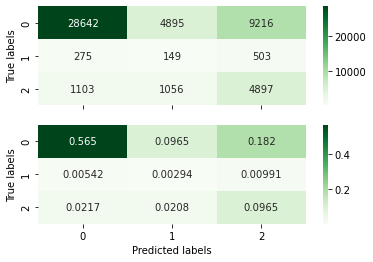

In [105]:
# multiclassova w/ is_unbalanced = True
lgb_model = lightgbm.LGBMClassifier(
                                        objective = 'multiclassova',
                                        is_unbalance = True
                                        )
lgb_model.fit(X_train, Y_train)
Y_preds = lgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.96      0.64      0.77     42753
           1       0.03      0.26      0.05       927
           2       0.35      0.64      0.45      7056

    accuracy                           0.63     50736
   macro avg       0.44      0.51      0.42     50736
weighted avg       0.85      0.63      0.71     50736


ACC: 	0.6320955534531694
MCC: 	0.2972985950459106
Confusion matrix: 


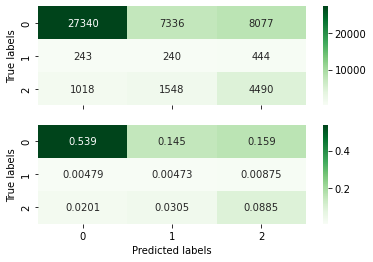

In [106]:
# multiclass + class_weight = 'balanced'
lgb_model = lightgbm.LGBMClassifier(
                                        objective='multiclass', 
                                        class_weight='balanced'
                                        )
lgb_model.fit(X_train, Y_train)
Y_preds = lgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.55      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8489435509303059
MCC: 	0.24824583799187694
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


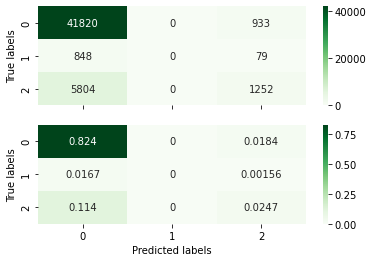

In [107]:
# one vs all approach
lgb_model = lightgbm.LGBMClassifier(objective='multiclassova', 
                        num_classes = 3,
                )
lgb_model.fit(X_train, Y_train)
Y_preds = lgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.17      0.26      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8489041311888994
MCC: 	0.2438186405109035
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


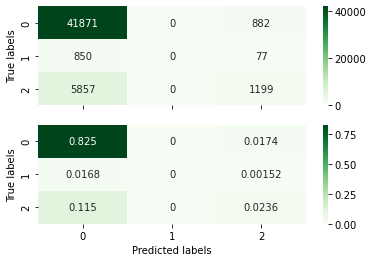

In [108]:
# one vs all approach
lgb_model = lightgbm.LGBMClassifier(objective='multiclassova', 
                        num_classes = 3,
                        scale_pos_weight = scp
                        
                )
lgb_model.fit(X_train, Y_train)
Y_preds = lgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

#### Undersampling

In [59]:
sampling_strategy = {0: 50000, 1:Y_train.value_counts().sort_index()[1], 2: Y_train.value_counts().sort_index()[2]}
sampling_strategy

{0: 50000, 1: 3704, 2: 28290}

In [60]:
rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = 20)

In [65]:
X_res, Y_res = rus.fit_resample(X_train,Y_train)
print(X_res.shape)
print(Y_train.value_counts())
print(Y_res.value_counts())

(81994, 21)
0    170950
2     28290
1      3704
Name: Diabetes_012, dtype: int64
0    50000
2    28290
1     3704
Name: Diabetes_012, dtype: int64


              precision    recall  f1-score   support

           0       0.90      0.71      0.80     42753
           1       0.03      0.07      0.04       927
           2       0.26      0.51      0.34      7056

    accuracy                           0.68     50736
   macro avg       0.39      0.43      0.39     50736
weighted avg       0.79      0.68      0.72     50736


ACC: 	0.6751024913276569
MCC: 	0.20032586533604324
Confusion matrix: 


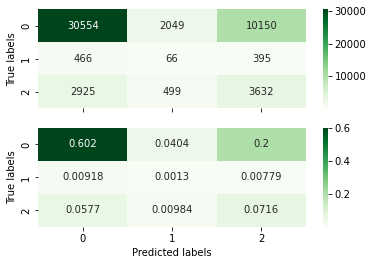

In [66]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_res, Y_res)
Y_preds = decision_tree.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.92      0.82      0.86     42753
           1       0.01      0.00      0.00       927
           2       0.35      0.63      0.45      7056

    accuracy                           0.77     50736
   macro avg       0.43      0.48      0.44     50736
weighted avg       0.82      0.77      0.79     50736


ACC: 	0.7745979186376537
MCC: 	0.3416218173352731
Confusion matrix: 


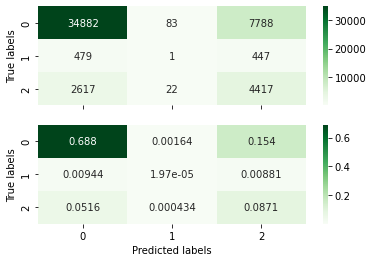

In [69]:
decision_tree = RandomForestClassifier(n_jobs = -1)
decision_tree.fit(X_res, Y_res)
Y_preds = decision_tree.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.92      0.82      0.86     42753
           1       0.01      0.00      0.00       927
           2       0.35      0.63      0.45      7056

    accuracy                           0.78     50736
   macro avg       0.43      0.48      0.44     50736
weighted avg       0.82      0.78      0.79     50736


ACC: 	0.7755637023021129
MCC: 	0.34326555455673213
Confusion matrix: 


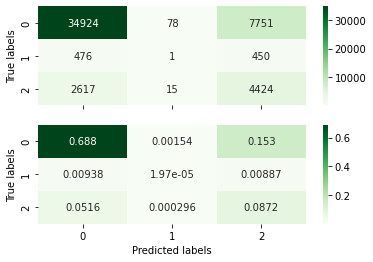

In [70]:
rf = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
rf.fit(X_res, Y_res)
Y_preds = rf.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87     42753
           1       0.01      0.00      0.00       927
           2       0.35      0.63      0.45      7056

    accuracy                           0.78     50736
   macro avg       0.43      0.48      0.44     50736
weighted avg       0.82      0.78      0.79     50736


ACC: 	0.776292967518133
MCC: 	0.34384383729475543
Confusion matrix: 


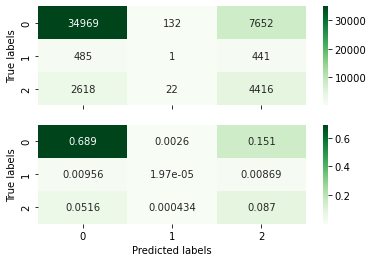

In [71]:
rf_model = RandomForestClassifier(class_weight = 'balanced', n_estimators=1000, n_jobs =-1)
rf_model.fit(X_res, Y_res)
Y_preds = rf_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.64      0.47      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7893803216650899
MCC: 	0.36910785946607505
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


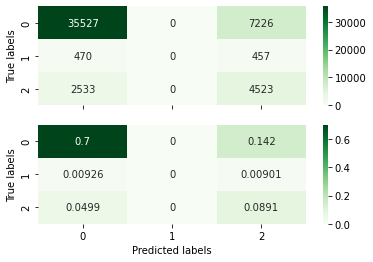

In [72]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_res, Y_res)
Y_preds = gbm_model.predict(X_test)
custom_logging(Y_test, Y_preds)

[21:09:24] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:09:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     42753
           1       0.22      0.00      0.00       927
           2       0.37      0.65      0.47      7056

    accuracy                           0.79     50736
   macro avg       0.50      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC

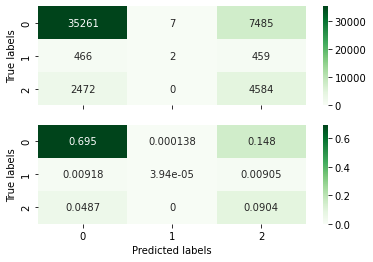

In [73]:
xgb_model = xgboost.XGBClassifier(objective = 'multi:softmax',
                use_label_encoder=False,
                num_classes = 3, 
                tree_method = 'gpu_hist')
xgb_model.fit(X_res, Y_res)
Y_preds = xgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.65      0.47      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7867983286029644
MCC: 	0.3701558587325853
Confusion matrix: 


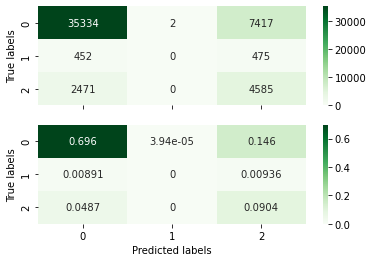

In [75]:
lgb_model = lightgbm.LGBMClassifier(objective='multiclass')
lgb_model.fit(X_res, Y_res)
Y_preds = lgb_model.predict(X_test)
custom_logging(Y_test, Y_preds)

### Exploring dimensionality reduction

After all, dimensionality reduction implied no additional benefits, since all of the tree based methods were fairly fast. Thus, after initial experimentation it was dropped.

#### PCA

In [82]:
# First scenario
dim_reduction_0 = PCA(n_components = 10)
dim_reduced_X_train_0 = dim_reduction_0.fit_transform(X_train)
dim_reduced_X_test_0 = dim_reduction_0.transform(X_test)

In [83]:
# Second scenario
dim_reduction_1 = PCA(n_components = .95)
dim_reduced_X_train_1 = dim_reduction_1.fit_transform(X_train)
dim_reduced_X_test_1 = dim_reduction_1.transform(X_test)

In [84]:
# Third scenario
dim_reduction_2 = PCA(n_components = .99)
dim_reduced_X_train_2 = dim_reduction_2.fit_transform(X_train)
dim_reduced_X_test_2 = dim_reduction_2.transform(X_test)

In [85]:
dim_reduced_X_train.shape

(202944, 10)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     42753
           1       0.03      0.03      0.03       927
           2       0.29      0.29      0.29      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.40      0.40     50736
weighted avg       0.78      0.77      0.77     50736


ACC: 	0.7727846105329549
MCC: 	0.16805379912284552
Confusion matrix: 


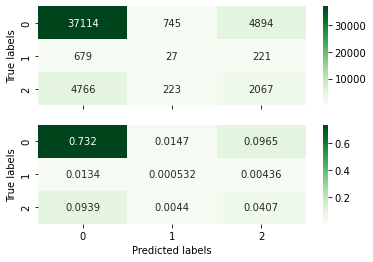

In [86]:

decision_tree_pca_0 = DecisionTreeClassifier()
decision_tree_pca_0.fit(dim_reduced_X_train_0, Y_train)
Y_preds = decision_tree_pca_0.predict(dim_reduced_X_test_0)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     42753
           1       0.03      0.03      0.03       927
           2       0.26      0.26      0.26      7056

    accuracy                           0.77     50736
   macro avg       0.39      0.39      0.39     50736
weighted avg       0.77      0.77      0.77     50736


ACC: 	0.7673052664774519
MCC: 	0.1420061666292144
Confusion matrix: 


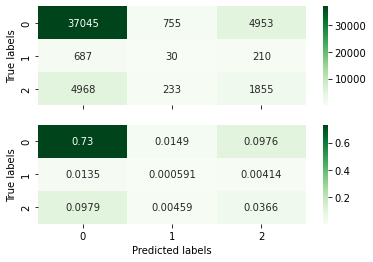

In [88]:
# PCA .95
decision_tree_pca_1 = DecisionTreeClassifier()
decision_tree_pca_1.fit(dim_reduced_X_train_1, Y_train)
Y_preds = decision_tree_pca_1.predict(dim_reduced_X_test_1)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     42753
           1       0.03      0.03      0.03       927
           2       0.29      0.30      0.29      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.40      0.40     50736
weighted avg       0.78      0.77      0.78     50736


ACC: 	0.7744402396720278
MCC: 	0.17147810290802226
Confusion matrix: 


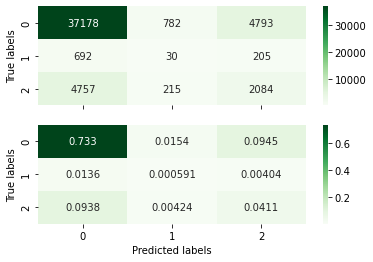

In [89]:
# PCA .99
decision_tree_pca_2 = DecisionTreeClassifier()
decision_tree_pca_2.fit(dim_reduced_X_train_2, Y_train)
Y_preds = decision_tree_pca_2.predict(dim_reduced_X_test_2)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.02      0.00      0.00       927
           2       0.47      0.16      0.24      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.38      0.38     50736
weighted avg       0.79      0.84      0.80     50736


ACC: 	0.8405668558814254
MCC: 	0.20249723120455304
Confusion matrix: 


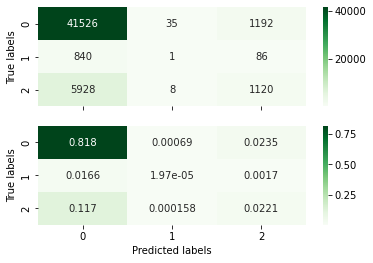

In [90]:

rf_pca_0 = RandomForestClassifier(n_jobs = -1)
rf_pca_0.fit(dim_reduced_X_train_0, Y_train)
Y_preds = rf_pca_0.predict(dim_reduced_X_test_0)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     42753
           1       0.03      0.00      0.01       927
           2       0.38      0.18      0.24      7056

    accuracy                           0.83     50736
   macro avg       0.42      0.38      0.38     50736
weighted avg       0.78      0.83      0.80     50736


ACC: 	0.8264545884578998
MCC: 	0.17559497155953893
Confusion matrix: 


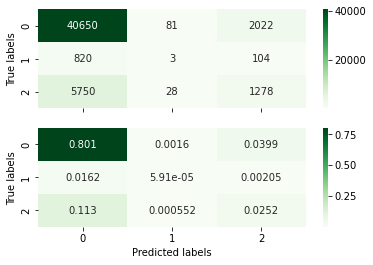

In [91]:

rf_pca_1 = RandomForestClassifier(n_jobs = -1)
rf_pca_1.fit(dim_reduced_X_train_1, Y_train)
Y_preds = rf_pca_1.predict(dim_reduced_X_test_1)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     42753
           1       0.03      0.00      0.00       927
           2       0.43      0.17      0.25      7056

    accuracy                           0.84     50736
   macro avg       0.44      0.38      0.39     50736
weighted avg       0.79      0.84      0.80     50736


ACC: 	0.8361518448438978
MCC: 	0.19701970491508786
Confusion matrix: 


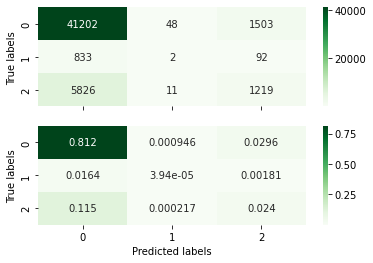

In [92]:
rf_pca_2 = RandomForestClassifier(n_jobs = -1)
rf_pca_2.fit(dim_reduced_X_train_2, Y_train)
Y_preds = rf_pca_2.predict(dim_reduced_X_test_2)
custom_logging(Y_test, Y_preds)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.52      0.17      0.26      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8458096814884895
MCC: 	0.23028245378900683
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


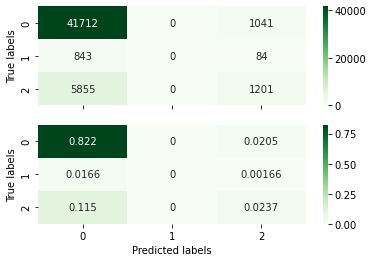

In [93]:

xgb_pca_0= xgboost.XGBClassifier(objective = 'multi:softmax', num_class = 3)
xgb_pca_0.fit(dim_reduced_X_train_0, Y_train)
Y_preds = xgb_pca_0.predict(dim_reduced_X_test_0)
custom_logging(Y_test, Y_preds)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     42753
           1       0.00      0.00      0.00       927
           2       0.51      0.08      0.14      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.36      0.35     50736
weighted avg       0.79      0.84      0.79     50736


ACC: 	0.844035793125197
MCC: 	0.15900300082903532
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


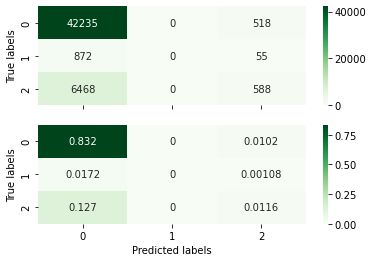

In [94]:

xgb_pca_1 = xgboost.XGBClassifier(objective = 'multi:softmax', num_class = 3)
xgb_pca_1.fit(dim_reduced_X_train_1, Y_train)
Y_preds = xgb_pca_1.predict(dim_reduced_X_test_1)
custom_logging(Y_test, Y_preds)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     42753
           1       0.00      0.00      0.00       927
           2       0.51      0.14      0.22      7056

    accuracy                           0.84     50736
   macro avg       0.46      0.37      0.38     50736
weighted avg       0.79      0.84      0.80     50736


ACC: 	0.8447059287291075
MCC: 	0.20389526800152197
Confusion matrix: 


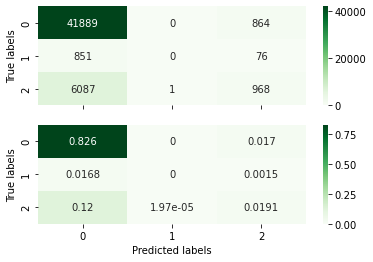

In [96]:

xgb_pca_2 = xgboost.XGBClassifier(objective = 'multi:softmax', num_class = 3)
xgb_pca_2.fit(dim_reduced_X_train_2, Y_train)
Y_preds = xgb_pca_2.predict(dim_reduced_X_test_2)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.16      0.25      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8471696625670135
MCC: 	0.2323384072673672
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


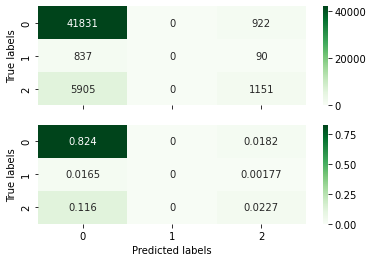

In [97]:
lgbm_pca_0 = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3)
lgbm_pca_0.fit(dim_reduced_X_train_0, Y_train)
Y_preds = lgbm_pca_0.predict(dim_reduced_X_test_0)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.16      0.25      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736


ACC: 	0.8471696625670135
MCC: 	0.2323384072673672
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


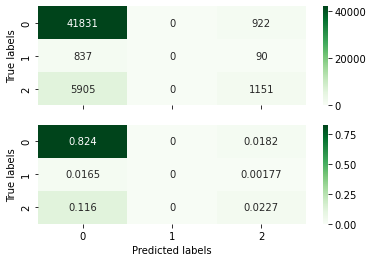

In [98]:
lgbm_pca_1 = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3)
lgbm_pca_1.fit(dim_reduced_X_train_1, Y_train)
y_preds = lgbm_pca_1.predict(dim_reduced_X_test_1)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.13      0.20      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.37      0.37     50736
weighted avg       0.80      0.85      0.80     50736


ACC: 	0.8460067801955219
MCC: 	0.20224173453987507
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


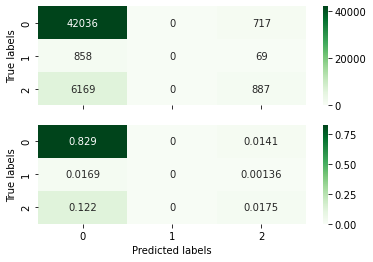

In [99]:
lgbm_pca_2 = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3)
lgbm_pca_2.fit(dim_reduced_X_train_2, Y_train)
Y_preds = lgbm_pca_2.predict(dim_reduced_X_test_2)
custom_logging(Y_test, Y_preds)

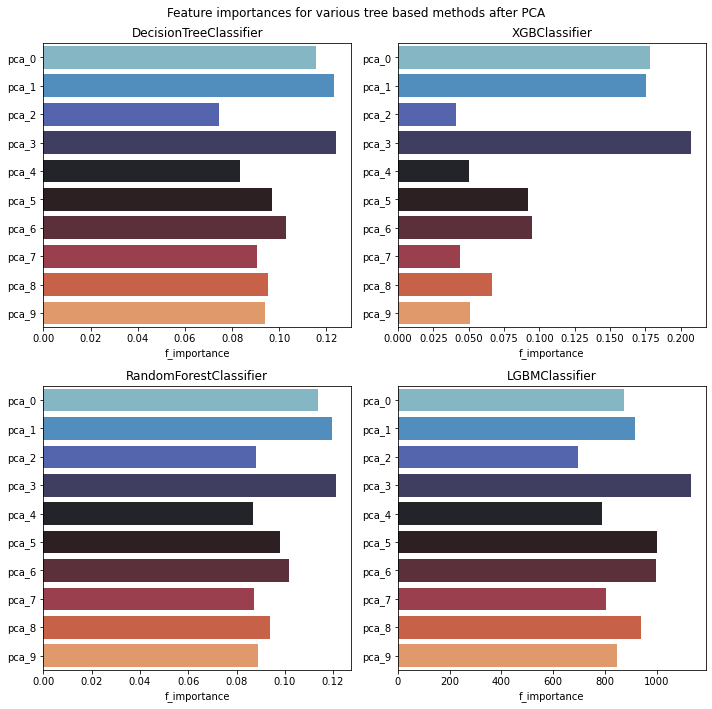

In [100]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train_0)
dim_features.columns = ["pca_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_pca_0, rf_pca_0, xgb_pca_0, lgbm_pca_0]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods after PCA")   
plt.tight_layout()
plt.savefig("plots/fi_pca")
plt.show()

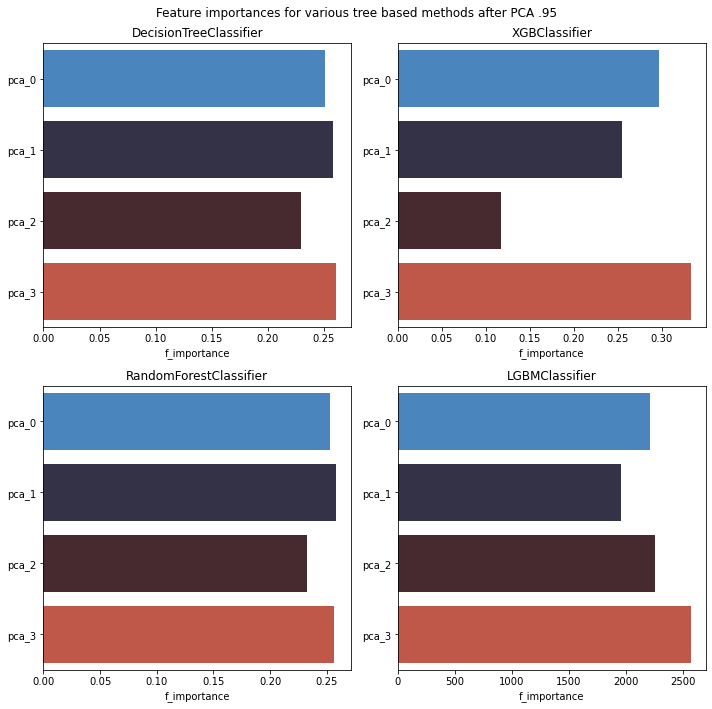

In [101]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train_1)
dim_features.columns = ["pca_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_pca_1, rf_pca_1, xgb_pca_1, lgbm_pca_1]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods after PCA .95")   
plt.tight_layout()
plt.savefig("plots/fi_pca")
plt.show()

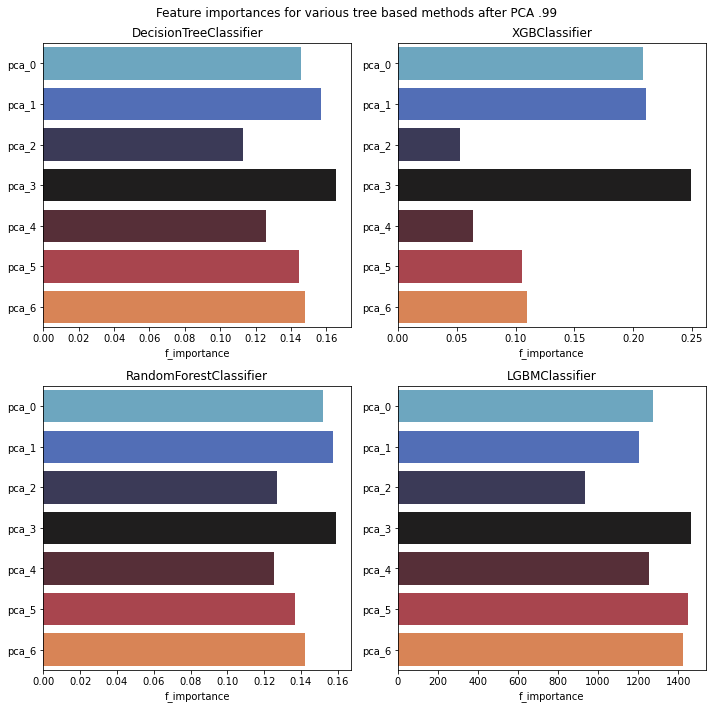

In [102]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train_2)
dim_features.columns = ["pca_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_pca_2, rf_pca_2, xgb_pca_2, lgbm_pca_2]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods after PCA .99")   
plt.tight_layout()
plt.savefig("plots/fi_pca")
plt.show()

#### UMAP

First, in a naive way, assume that an appropriate value for the number of UMAP dimensions could be the same as for PCA.

In [18]:
dim_reduction = umap.umap_.UMAP(n_components = 10)
dim_reduced_X_train = dim_reduction.fit_transform(X_train)
dim_reduced_X_test = dim_reduction.transform(X_test)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [19]:
with mlflow.start_run(run_name = "DT, umap = 10", experiment_id = 1) as run:
    decision_tree_umap = DecisionTreeClassifier()
    decision_tree_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = decision_tree_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



2022/01/09 00:35:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     42753
           1       0.03      0.03      0.03       927
           2       0.26      0.28      0.27      7056

    accuracy                           0.76     50736
   macro avg       0.38      0.39      0.39     50736
weighted avg       0.77      0.76      0.76     50736

MAE: 	0.4460935036266162
MSE: 	0.8518014821822769
ACC: 	0.7567604856512141
MCC: 	0.13613438406695985


In [20]:
with mlflow.start_run(run_name = "RF, umap = 10", experiment_id = 1) as run:
    rf_umap = RandomForestClassifier()
    rf_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = rf_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



2022/01/09 00:36:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.96      0.91     42753
           1       0.02      0.00      0.00       927
           2       0.39      0.14      0.21      7056

    accuracy                           0.83     50736
   macro avg       0.42      0.37      0.37     50736
weighted avg       0.78      0.83      0.79     50736

MAE: 	0.31547619047619047
MSE: 	0.6117943866288237
ACC: 	0.8326829076001262
MCC: 	0.16273817146559996


In [22]:
with mlflow.start_run(run_name = "XGB, umap = 10", experiment_id = 1) as run:
    xgb_umap = xgboost.XGBClassifier()
    xgb_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = xgb_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     42753
           1       0.00      0.00      0.00       927
           2       0.48      0.04      0.08      7056

    accuracy                           0.84     50736
   macro avg       0.44      0.35      0.33     50736
weighted avg       0.78      0.84      0.78     50736

MAE: 	0.29669268369599494
MSE: 	0.5751143172500789
ACC: 	0.842518133081047
MCC: 	0.10587732710579573


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [23]:
with mlflow.start_run(run_name = "LGBM, umap = 10", experiment_id = 1) as run:
    lgbm_umap = lightgbm.LGBMClassifier()
    lgbm_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = lgbm_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.85      1.00      0.91     42753
           1       0.00      0.00      0.00       927
           2       0.51      0.03      0.06      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.34      0.32     50736
weighted avg       0.78      0.84      0.78     50736

MAE: 	0.2953918322295806
MSE: 	0.5725126143172501
ACC: 	0.8431685588142542
MCC: 	0.09377670889739859


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

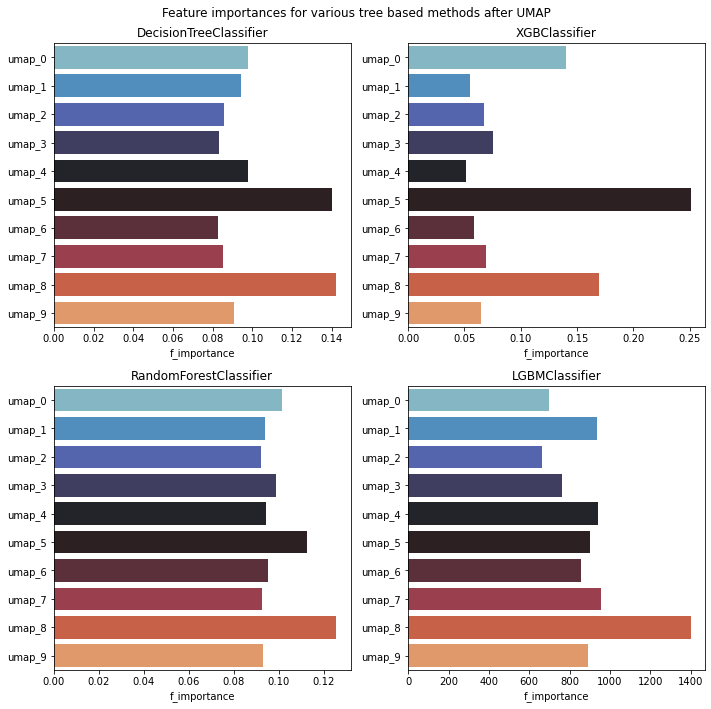

In [24]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train)
dim_features.columns = ["umap_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_umap, rf_umap, xgb_umap, lgbm_umap]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1
    
plt.suptitle("Feature importances for various tree based methods after UMAP")   
plt.tight_layout()
plt.savefig("plots/fi_umap")
plt.show()

One idea was to consider UMAP's parameters as a hyperparameter to tune in a pipeline; However, as it was not as useful in terms of model improvement or training time, this idea was dropped.

#### Binning

In [16]:
data.nunique().sort_values(ascending = False)

BMI                     84
PhysHlth                31
MentHlth                31
Age                     13
Income                   8
Education                6
GenHlth                  5
Diabetes_012             3
PhysActivity             2
Fruits                   2
Veggies                  2
HighBP                   2
AnyHealthcare            2
NoDocbcCost              2
HeartDiseaseorAttack     2
Stroke                   2
Smoker                   2
DiffWalk                 2
Sex                      2
CholCheck                2
HighChol                 2
HvyAlcoholConsump        2
dtype: int64

In [24]:
nonbinary_features = data[['BMI', 'PhysHlth', 'MentHlth', 'Age', 'Income', 'Education', 'GenHlth' ]]
nonbinary_features.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
PhysHlth,253680.0,4.242081,8.717951,0.0,0.0,0.0,3.0,30.0
MentHlth,253680.0,3.184772,7.412847,0.0,0.0,0.0,2.0,30.0
Age,253680.0,8.032119,3.054220,1.0,6.0,8.0,10.0,13.0
Income,253680.0,6.053875,2.071148,1.0,5.0,7.0,8.0,8.0
Education,253680.0,5.050434,0.985774,1.0,4.0,5.0,6.0,6.0
GenHlth,253680.0,2.511392,1.068477,1.0,2.0,2.0,3.0,5.0


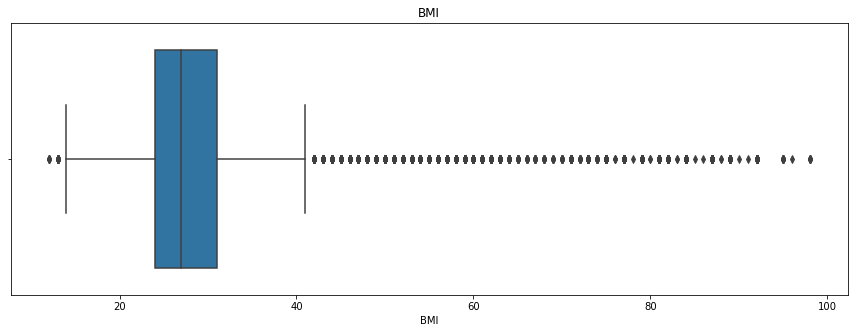

In [126]:
plt.figure(figsize=(15,5))
sns.boxplot(x = data['BMI']).set_title("BMI")
plt.show()

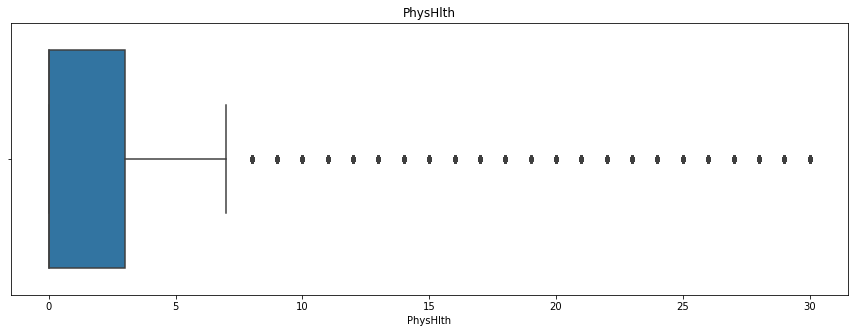

In [128]:
plt.figure(figsize=(15,5))
sns.boxplot(x = data['PhysHlth']).set_title("PhysHlth")
plt.show()

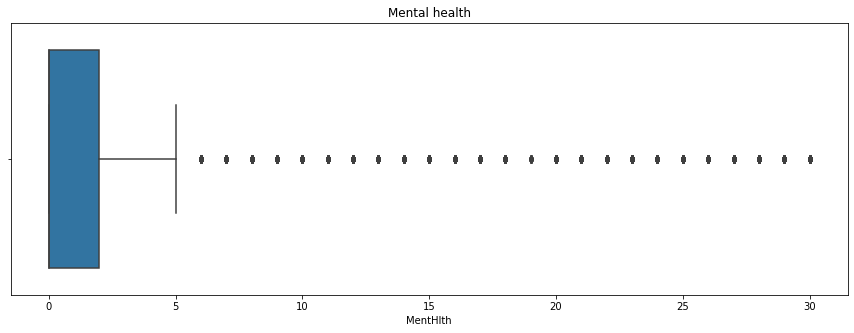

In [132]:
plt.figure(figsize=(15,5))
sns.boxplot(x = data['MentHlth'],).set_title("Mental health")
plt.show()

Try a decision tree for binning.

In [35]:
Xt = X_train[['BMI']]
Yt = Y_train

In [76]:
params = {'max_depth':[2, 3, 4, 6, 8],  'min_samples_split':[2,3,5,10]}
binning_DT = DecisionTreeClassifier()
search = GridSearchCV(binning_DT, param_grid = params, scoring = 'accuracy')
search.fit(Xt, Yt)

2022/01/09 15:13:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cce05788a4bc4336942b5e7d47c35b40', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/01/09 15:13:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='accuracy')

In [77]:
search.best_params_

{'max_depth': 2, 'min_samples_split': 2}

In [36]:
binning_DT = DecisionTreeClassifier(max_depth = None, min_samples_split = 2)
binning_DT.fit(Xt, Yt)

2022/01/11 14:38:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e41090754d934d15890148cf643762bd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


DecisionTreeClassifier()

In [37]:
np.unique(binning_DT.predict(Xt))

array([0., 1., 2.])

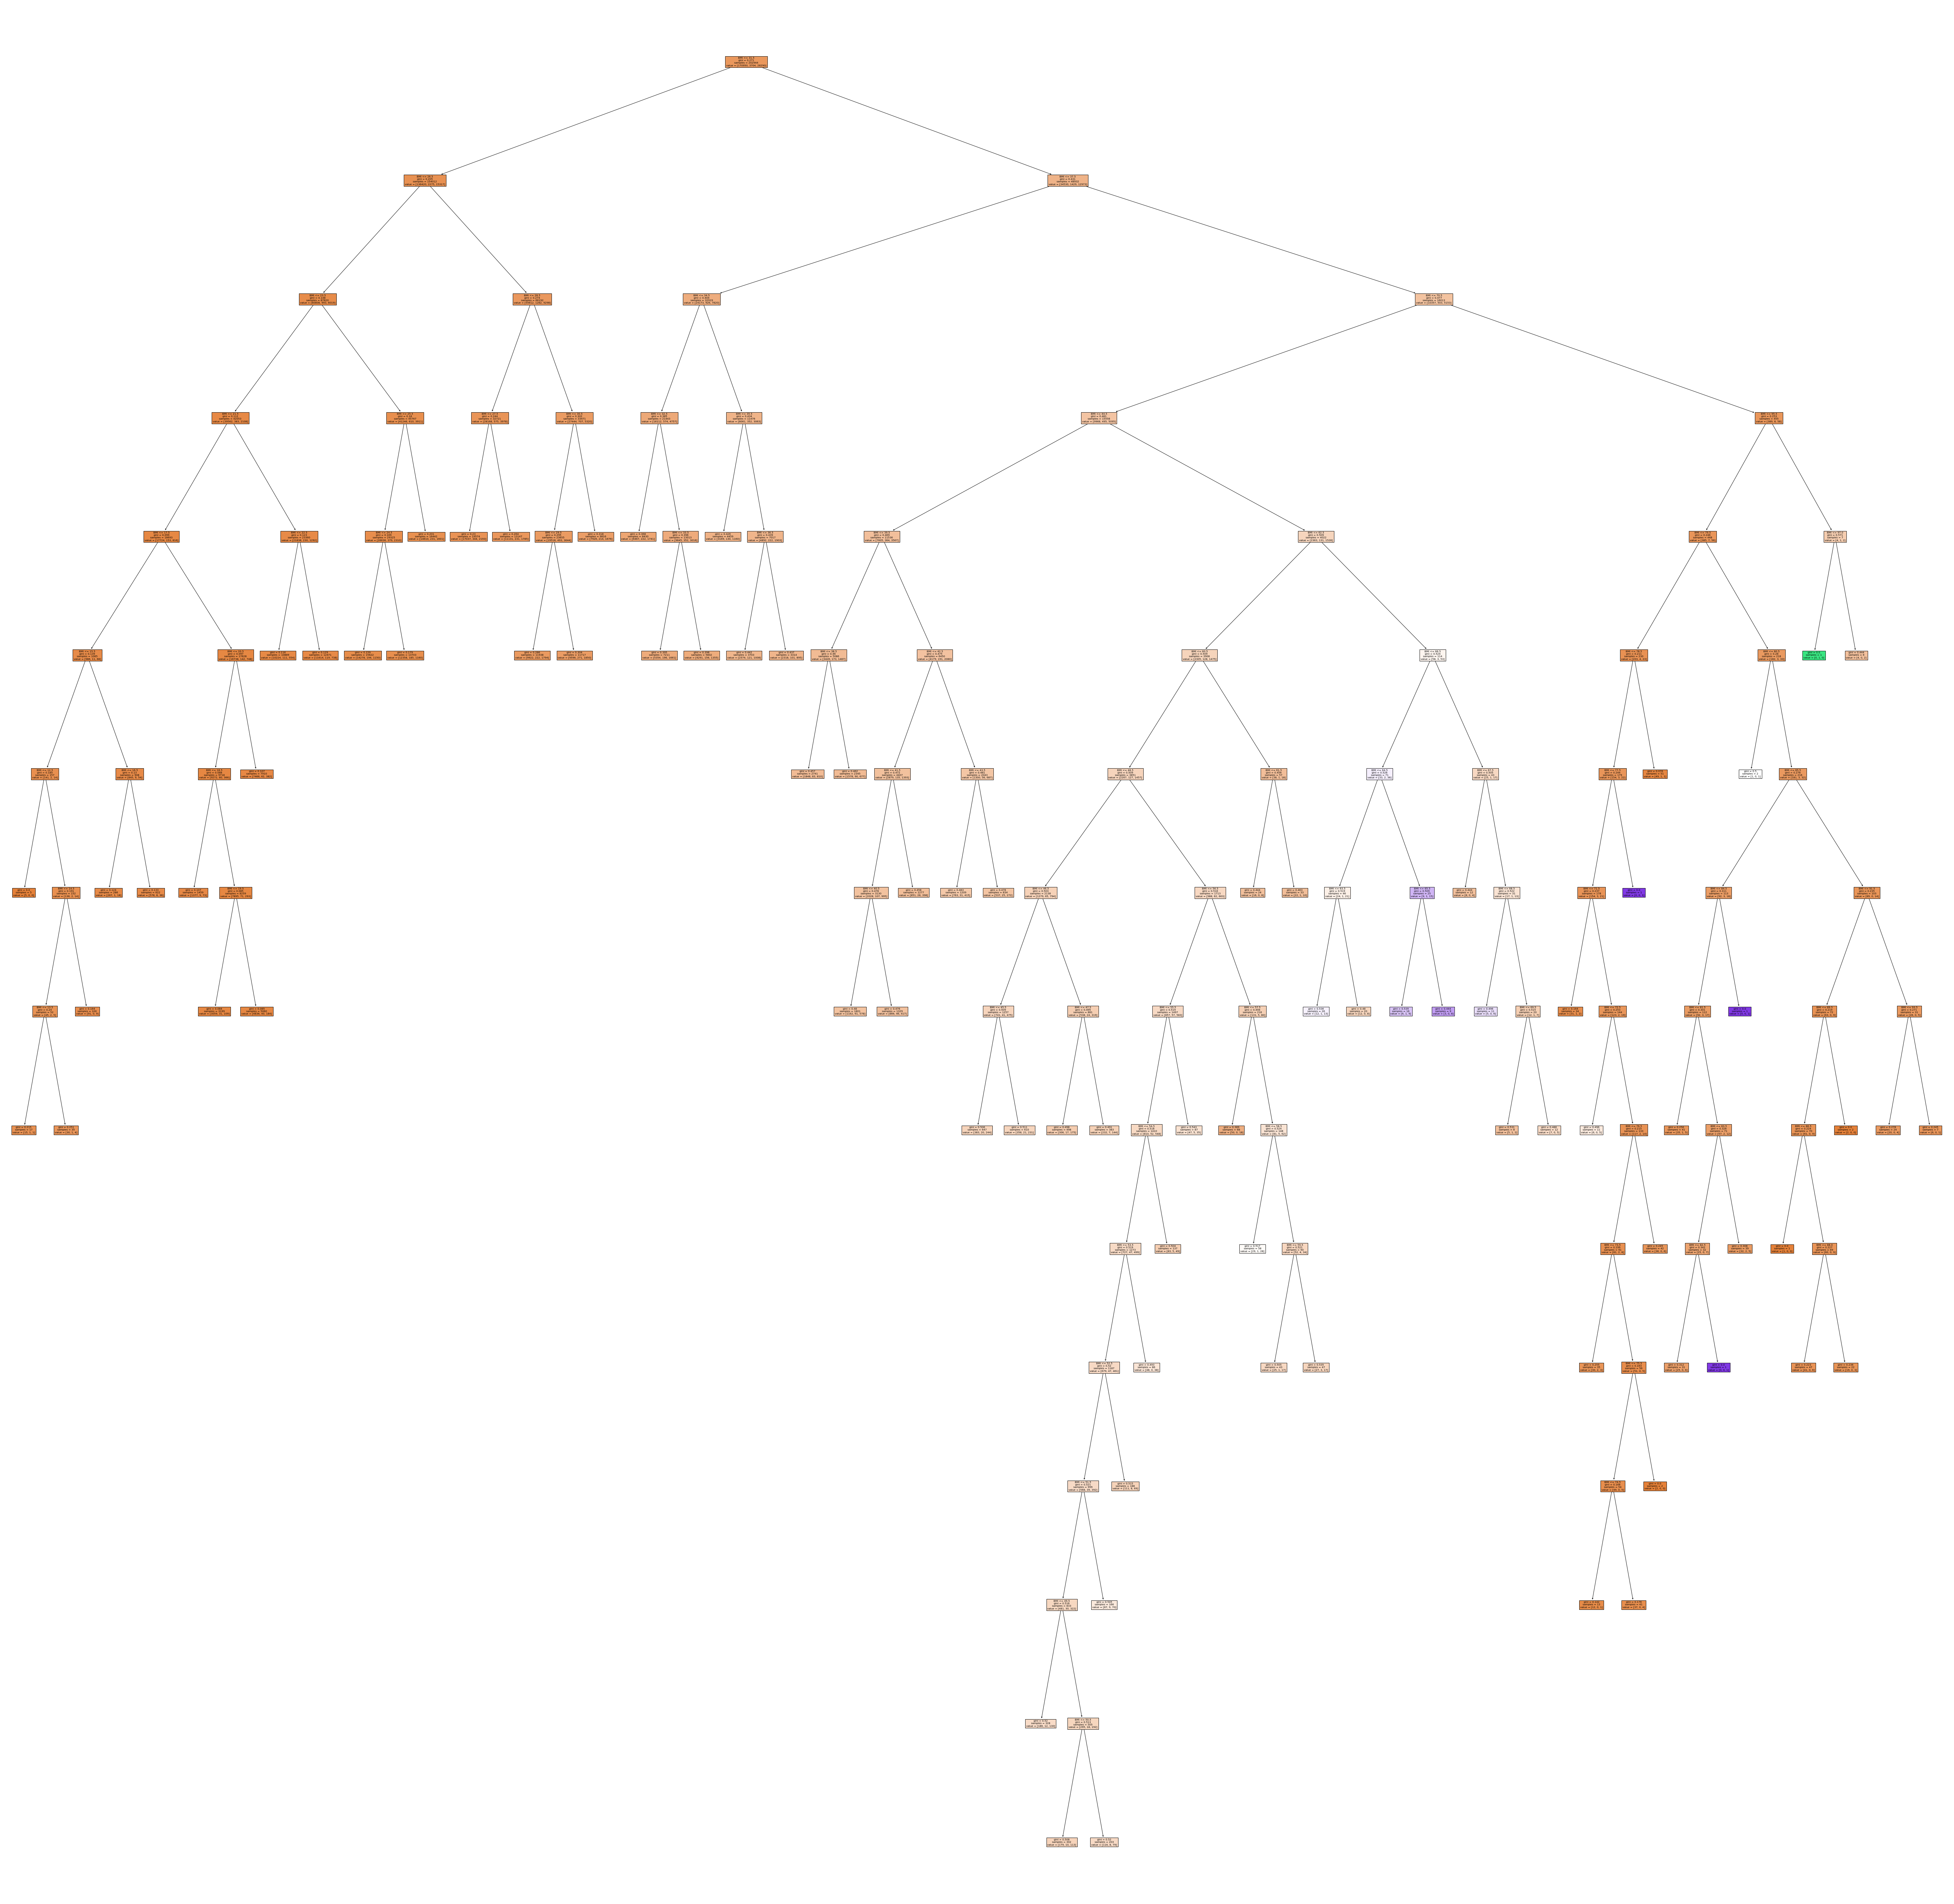

In [42]:
plt.figure(figsize= (100, 100))
tree.plot_tree(binning_DT, filled = True, feature_names = ['BMI'])
plt.savefig('plots/dt_tree')
plt.show()

For age it shouldn't make that much sense as it has been already transformed from nominal to categorical, having 13 age labels.

In [84]:
Xa = X_train[['Age']]
params = {'max_depth':[2, 3, 4, 6, 8],  'min_samples_split':[2,3,5,10]}
binningAge_DT = DecisionTreeClassifier()
search = GridSearchCV(binningAge_DT, param_grid = params, scoring = 'accuracy')
search.fit(Xa, Yt)

2022/01/09 15:17:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c95f881dd27346f5ae1044789005cf24', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/01/09 15:17:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='accuracy')

In [85]:
search.best_params_

{'max_depth': 2, 'min_samples_split': 2}

In [86]:
search.best_estimator_

DecisionTreeClassifier(max_depth=2)

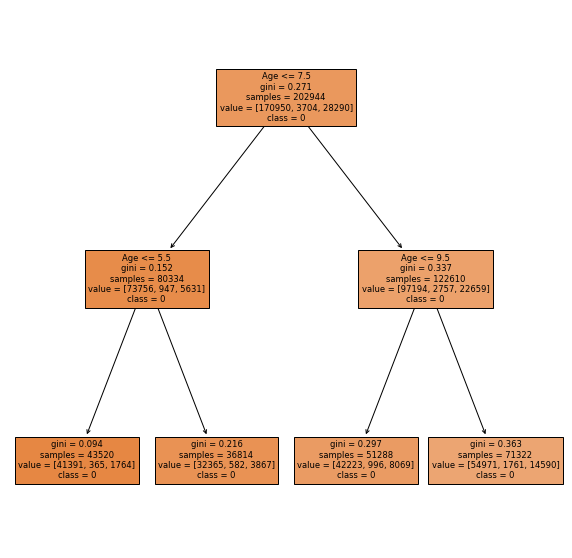

In [89]:
plt.figure(figsize= (10, 10))
tree.plot_tree(search.best_estimator_, filled = True, feature_names = ['Age'], class_names = ['0','1','2'])
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Count'>

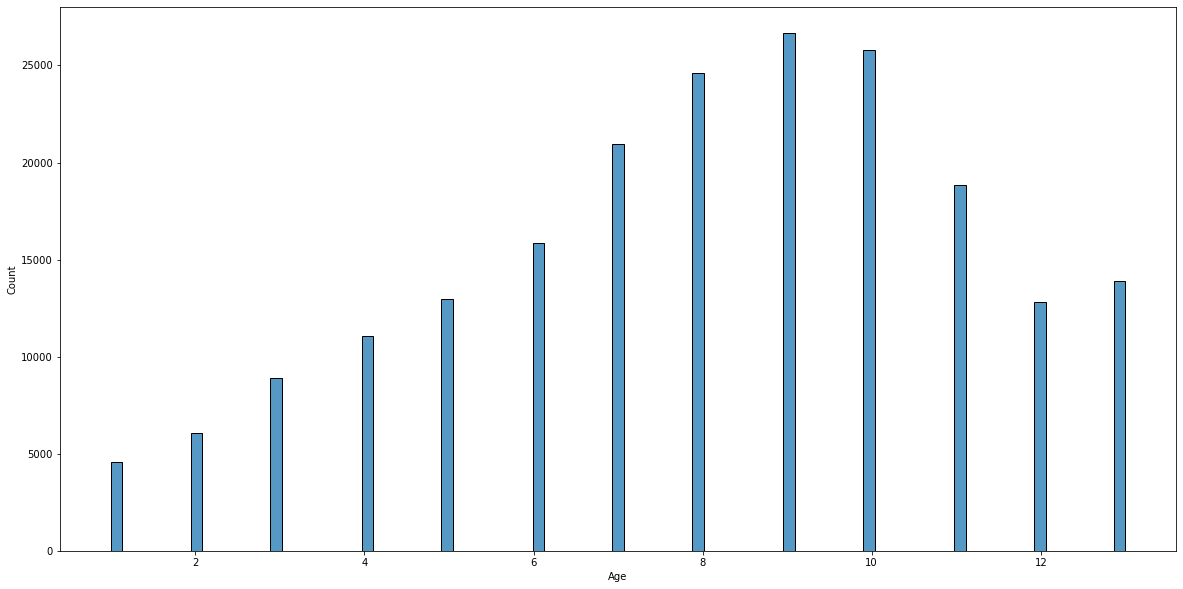

In [45]:
plt.figure(figsize = (20,10))
sns.histplot(X_train.Age)

In [108]:
X_train.Age.value_counts()

9.0     26668
10.0    25803
8.0     24620
7.0     20947
11.0    18838
6.0     15867
13.0    13884
5.0     12960
12.0    12797
4.0     11050
3.0      8900
2.0      6059
1.0      4551
Name: Age, dtype: int64

<AxesSubplot:xlabel='PhysHlth', ylabel='Count'>

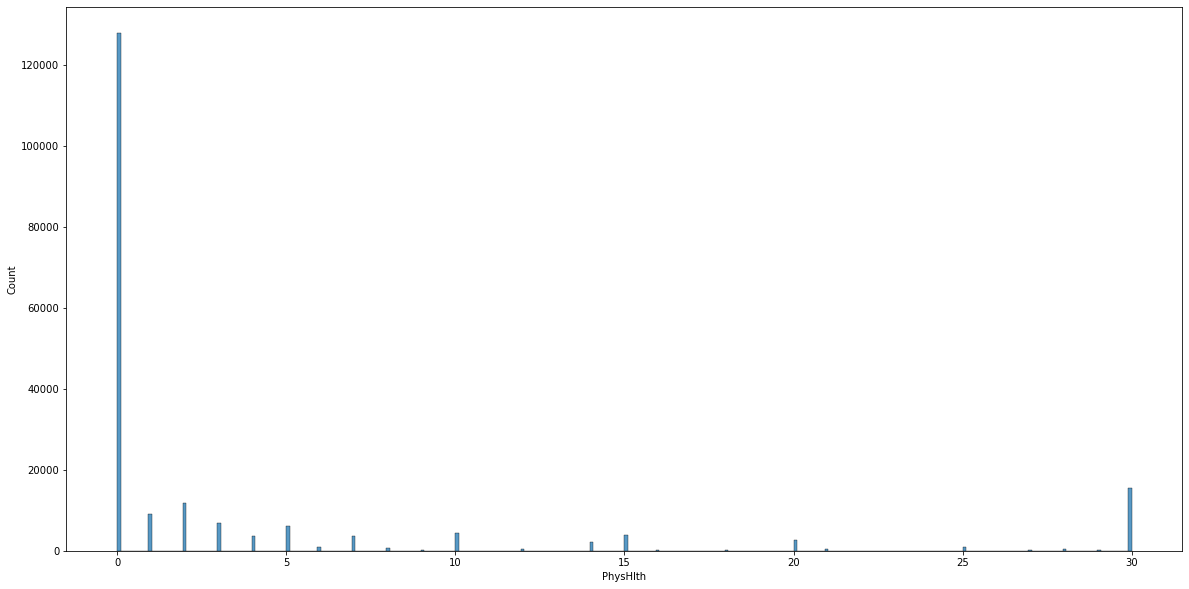

In [46]:
plt.figure(figsize = (20,10))

sns.histplot(X_train.PhysHlth)

In [47]:
Xa = X_train[['PhysHlth']]
params = {'max_depth':[2, 3, 4, 6, 8],  'min_samples_split':[2,3,5,10]}
binningAge_DT = DecisionTreeClassifier()
search = GridSearchCV(binningAge_DT, param_grid = params, scoring = 'accuracy')
search.fit(Xa, Yt)

2022/01/11 14:44:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '17d4f206d7474fbcab5f8874407f2bf5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/01/11 14:44:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, 15 runs will be omitted.


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='accuracy')

In [93]:
search.best_params_

{'max_depth': 2, 'min_samples_split': 2}

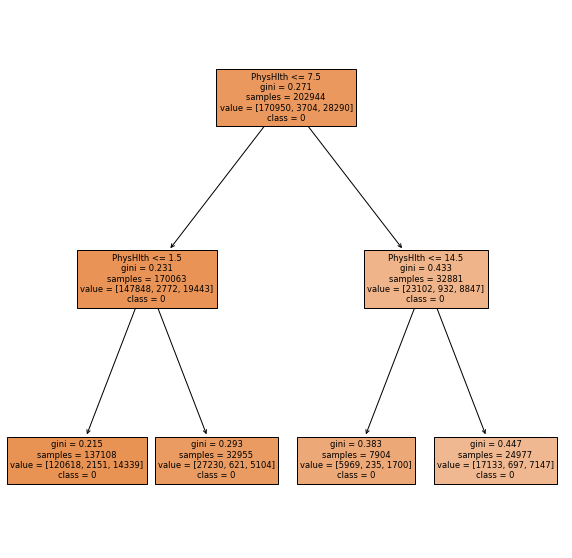

In [48]:
plt.figure(figsize= (10, 10))
tree.plot_tree(search.best_estimator_, filled = True, feature_names = ['PhysHlth'], class_names = ['0','1','2'])
plt.show()

### New features: Polynomial combinations

In [20]:
from copy import deepcopy

In [21]:
new_data = deepcopy(data)
poly_corr = pd.read_csv('data/correlations.csv')
poly_corr.columns = ['poly_feature', 'corr']

In [22]:
poly_corr['corr'].abs().sort_values(ascending=False)[:100]

21906    0.347600
22116    0.347073
27102    0.345546
24582    0.345546
19542    0.345546
           ...   
24216    0.305484
17146    0.305217
24122    0.305217
17121    0.305217
17022    0.305217
Name: corr, Length: 100, dtype: float64

In [23]:
additional_features = poly_corr[poly_corr['corr'].abs()>0.305487]['poly_feature'].values
additional_features
  

array(['HighBP^0.5 *GenHlth^0.5', 'BMI^0.5 *GenHlth^0.5',
       'GenHlth^0.5 *Age^0.5', 'HighBP^0.5 *BMI^1.0',
       'HighBP^0.5 *GenHlth^1.0', 'BMI^0.5 *GenHlth^1.0',
       'HighBP^0.5 *BMI^1.5', 'HighBP^0.5 *GenHlth^1.5',
       'HighChol^0.5 *GenHlth^1.5', 'CholCheck^0.5 *GenHlth^1.5',
       'BMI^0.5 *GenHlth^1.5', 'HighBP^0.5 *BMI^2.0',
       'HighBP^0.5 *GenHlth^2.0', 'HighChol^0.5 *GenHlth^2.0',
       'CholCheck^0.5 *GenHlth^2.0', 'BMI^0.5 *GenHlth^2.0',
       'HighBP^0.5 *GenHlth^2.5', 'HighChol^0.5 *GenHlth^2.5',
       'BMI^0.5 *GenHlth^2.5', 'HighBP^1.0 *GenHlth^0.5',
       'BMI^1.0 *GenHlth^0.5', 'GenHlth^1.0 *Age^0.5',
       'HighBP^1.0 *BMI^1.0', 'HighBP^1.0 *GenHlth^1.0',
       'BMI^1.0 *GenHlth^1.0', 'GenHlth^1.0 *Age^1.0',
       'HighBP^1.0 *BMI^1.5', 'HighBP^1.0 *GenHlth^1.5',
       'HighChol^1.0 *GenHlth^1.5', 'CholCheck^1.0 *GenHlth^1.5',
       'BMI^1.0 *GenHlth^1.5', 'GenHlth^1.0 *Age^1.5',
       'HighBP^1.0 *BMI^2.0', 'HighBP^1.0 *GenHlth^2.0',
      

In [24]:
len(additional_features)

95

In [25]:
ndf = pd.DataFrame()
for new_feature in additional_features:
    split_feature = new_feature.split('*')
    first_f = split_feature[0]
    second_f = split_feature[1]
    f1_split = first_f.split('^')
    f2_split = second_f.split('^')
    new_column = new_data[f1_split[0]]**float(f1_split[1]) * new_data[f2_split[0]]**float(f2_split[1])
    new_data[new_feature] = new_column


In [26]:
new_data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,HighBP^2.5 *GenHlth^1.5,HighChol^2.5 *GenHlth^1.5,CholCheck^2.5 *GenHlth^1.5,GenHlth^2.5 *Age^1.5,HighBP^2.5 *BMI^2.0,HighBP^2.5 *GenHlth^2.0,HighChol^2.5 *GenHlth^2.0,CholCheck^2.5 *GenHlth^2.0,HighBP^2.5 *GenHlth^2.5,HighChol^2.5 *GenHlth^2.5
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,11.180340,11.180340,11.180340,1509.345885,1600.0,25.0,25.0,25.0,55.901699,55.901699
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,288.702269,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,11.180340,11.180340,11.180340,1509.345885,784.0,25.0,25.0,25.0,55.901699,55.901699
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,2.828427,0.000000,2.828427,206.378293,729.0,4.0,0.0,4.0,5.656854,0.000000
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,2.828427,2.828427,2.828427,206.378293,576.0,4.0,4.0,4.0,5.656854,5.656854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,5.196152,5.196152,5.196152,174.284251,2025.0,9.0,9.0,9.0,15.588457,15.588457
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,8.000000,8.000000,8.000000,1167.451926,324.0,16.0,16.0,16.0,32.000000,32.000000
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,0.000000,0.000000,1.000000,2.828427,0.0,0.0,0.0,1.0,0.000000,0.000000
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,5.196152,0.000000,5.196152,288.702269,529.0,9.0,0.0,9.0,15.588457,0.000000


In [27]:
X, Y = new_data.drop("Diabetes_012", axis = 1), data['Diabetes_012']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

In [28]:
# Undersampling the newly created dataset
sampling_strategy = {0: 50000, 1:Y_train.value_counts().sort_index()[1], 2: Y_train.value_counts().sort_index()[2]}
rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = 20)

X_res, Y_res = rus.fit_resample(X_train,Y_train)
print(X_res.shape)

print("Original dataset: ")
print(Y_train.value_counts())
print("Resampled dataset:")
print(Y_res.value_counts())

(81994, 116)
Original dataset: 
0.0    170950
2.0     28290
1.0      3704
Name: Diabetes_012, dtype: int64
Resampled dataset:
0.0    50000
2.0    28290
1.0     3704
Name: Diabetes_012, dtype: int64


#### Models w/ resampled data

              precision    recall  f1-score   support

           0       0.90      0.72      0.80     42753
           1       0.02      0.06      0.03       927
           2       0.25      0.51      0.34      7056

    accuracy                           0.68     50736
   macro avg       0.39      0.43      0.39     50736
weighted avg       0.79      0.68      0.72     50736


ACC: 	0.6767975402081362
MCC: 	0.1981583031230373
Confusion matrix: 


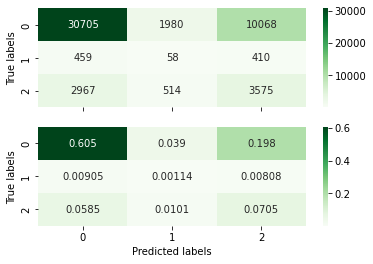

In [185]:
dt_nf = DecisionTreeClassifier()
dt_nf.fit(X_res, Y_res)
Y_preds = dt_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85     42753
           1       0.02      0.01      0.01       927
           2       0.33      0.61      0.43      7056

    accuracy                           0.76     50736
   macro avg       0.42      0.47      0.43     50736
weighted avg       0.82      0.76      0.78     50736


ACC: 	0.758179596341848
MCC: 	0.3146884020866703
Confusion matrix: 


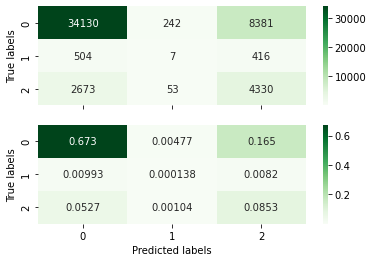

In [186]:

rf_nf = RandomForestClassifier(n_jobs=-1)
rf_nf.fit(X_res, Y_res)
Y_preds = rf_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.65      0.47      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7860296436455377
MCC: 	0.36932716839932833
Confusion matrix: 


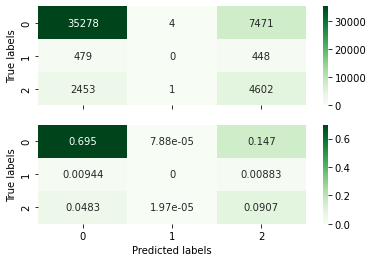

In [193]:

xgb_nf = xgboost.XGBClassifier(objective='multi:softmax',
                                tree_method = 'gpu_hist')
xgb_nf.fit(X_res, Y_res)
Y_preds = xgb_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

In [194]:
xgb_nf.best_iteration

99

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.66      0.47      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7882962787764112
MCC: 	0.37495160799986516
Confusion matrix: 


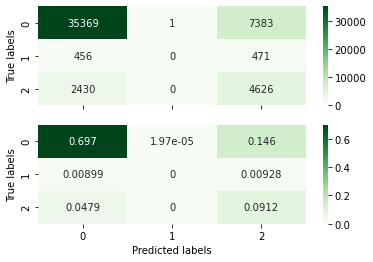

In [188]:
lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass')
lgbm_nf.fit(X_res, Y_res)
Y_preds = lgbm_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

In [189]:
lgbm_nf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [199]:
fi_subset = pd.DataFrame(xgb_nf.feature_importances_, index = features,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False).iloc[:10]

In [200]:
fi_subset

,f_importance
GenHlth^2.5 *Age^1.5,0.206122
HighBP^0.5 *GenHlth^0.5,0.177547
GenHlth^2.5 *Age^1.0,0.172499
GenHlth^1.5 *Age^0.5,0.083359
GenHlth^1.5 *Age^1.0,0.056730
GenHlth^1.0 *Age^0.5,0.034639
HighBP^0.5 *BMI^1.0,0.025688
HighChol^0.5 *GenHlth^1.5,0.019884
HighBP,0.015849
HighChol,0.013463


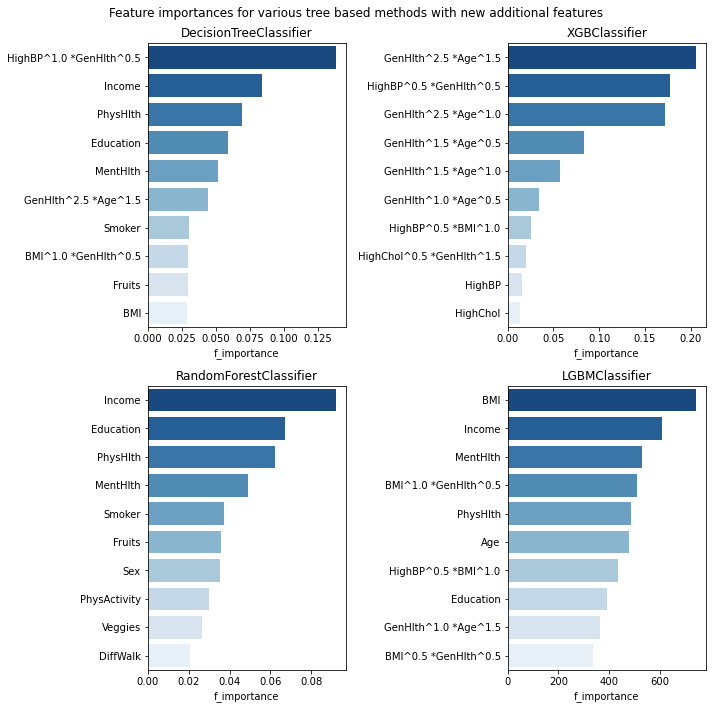

In [205]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10), sharey = False)
features = X_train.columns
i, j = 0, 0
for model in [dt_nf, rf_nf, xgb_nf, lgbm_nf]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = features,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False).iloc[:10]
    
    sns.barplot(y = fi_subset.index, x = fi_subset.f_importance, ax = axs[i][j],
    palette = 'Blues_r'
    ).set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods with new additional features")   
plt.tight_layout()
plt.savefig("plots/fi_added_poli_features")
plt.show()

### Hyperparameter searches

#### Optuna 1 - LGBM

In [206]:
def objective(trial, X, Y):
    param_grid = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 12000, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),

        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
        "feature_fraction", 0.2, 0.95, step=0.1
        )
    }

    search  = StratifiedKFold(n_splits=10, shuffle = True, random_state=20)

    scores = []
    
    for i, (train_i, test_i) in enumerate(search.split(X, Y)):
        X_train_, X_test_ = X.iloc[train_i], X.iloc[test_i]
        Y_train_, Y_test_ = Y.iloc[train_i], Y.iloc[test_i]

        model = lightgbm.LGBMClassifier(objective = 'multiclass', num_class = 3, **param_grid)
        model.fit(
            X_train_, Y_train_,
            eval_set = [(X_test_, Y_test_)], 
            early_stopping_rounds = 50,
            callbacks=[LightGBMPruningCallback(trial, metric = 'multi_logloss')]
        )

        Y_preds_ = model.predict(X_test_)

        acc = accuracy_score(Y_test_, Y_preds_)
        scores.append(acc)

    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='LGBM hyperparam search 1')
func = lambda trial: objective(trial, X_res, Y_res)
study.optimize(func, n_trials=5)

In [208]:
study.best_params

{'n_estimators': 4900,
 'learning_rate': 0.19804915331060768,
 'num_leaves': 2080,
 'max_depth': 8,
 'min_data_in_leaf': 6600,
 'lambda_l1': 15,
 'lambda_l2': 30,
 'min_gain_to_split': 7.292659508920586,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.5}

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_gain_to_split is set=7.292659508920586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.292659508920586
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      0.84      0.88     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.62      0.46      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7912330495111952
MCC: 	0.3605660737377346
Confusion matrix: 


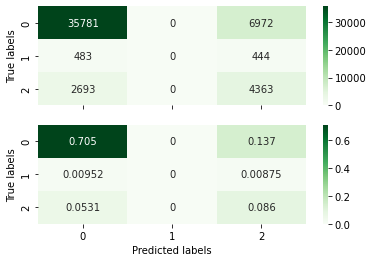

In [209]:
lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3, **study.best_params)
lgbm_nf.fit(X_res, Y_res)
Y_preds = lgbm_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

In [ ]:
study.optimize(func, n_trials=250)

In [213]:
study.best_params

{'n_estimators': 4900,
 'learning_rate': 0.19804915331060768,
 'num_leaves': 2080,
 'max_depth': 8,
 'min_data_in_leaf': 6600,
 'lambda_l1': 15,
 'lambda_l2': 30,
 'min_gain_to_split': 7.292659508920586,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.5}

In [74]:
modified_params = study.best_params
modified_params

{'n_estimators': 3900,
 'learning_rate': 0.27958454463927895,
 'num_leaves': 940,
 'max_depth': 10,
 'min_data_in_leaf': 5100,
 'lambda_l1': 30,
 'lambda_l2': 70,
 'min_gain_to_split': 12.049792659399,
 'bagging_fraction': 0.2,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      0.84      0.88     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.62      0.46      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7912330495111952
MCC: 	0.3605660737377346
Confusion matrix: 


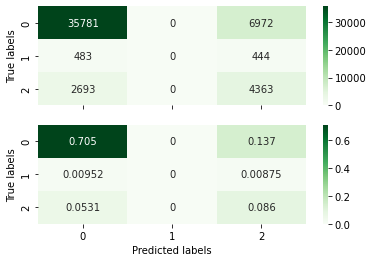

In [214]:

lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass', num_classes = 3, **study.best_params)
lgbm_nf.fit(X_res, Y_res)
Y_preds = lgbm_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

#### Optuna 2

Decrease learning rate, and modify the params based on the best params of the previous step. Change Kfold to k = 10. ~~Set the objective, based on the initial experimentation to the configuration that yielded the best initial performance in terms of mcc.~~

In [224]:
def objective(trial, X, Y):
    param_grid = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 12000, 200),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),

        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        )
    }

    search  = StratifiedKFold(n_splits=10, shuffle = True, random_state=25)

    scores = []

    for i, (train_i, test_i) in enumerate(search.split(X, Y)):
        X_train_, X_test_ = X.iloc[train_i], X.iloc[test_i]
        Y_train_, Y_test_ = Y.iloc[train_i], Y.iloc[test_i]

        model = lightgbm.LGBMClassifier(objective = 'multiclass',
                                        num_class = 3,
                                        learning_rate = .05,
                                        **param_grid)
        model.fit(
            X_train_, Y_train_,
            eval_set = [(X_test_, Y_test_)], 
            early_stopping_rounds = 50,
            callbacks=[LightGBMPruningCallback(trial, metric = 'multi_logloss')]
        )

        Y_preds_ = model.predict(X_test_)

        acc = accuracy_score(Y_test_, Y_preds_)
        scores.append(acc)

    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='LGBM hyperparam search 2')
func = lambda trial: objective(trial, X_res, Y_res)
study.optimize(func, n_trials = 10)

In [226]:
study.best_params

{'n_estimators': 900,
 'num_leaves': 160,
 'max_depth': 15,
 'min_data_in_leaf': 9800,
 'lambda_l1': 60,
 'lambda_l2': 5,
 'min_gain_to_split': 3.421224470737884,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_gain_to_split is set=3.421224470737884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.421224470737884
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
         

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


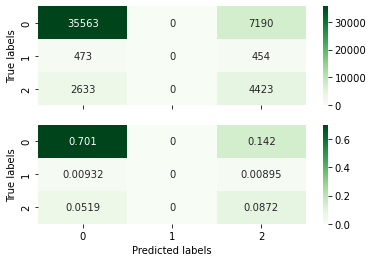

In [227]:
# So this is on the whole dataset(w/ added features)
lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass',
                                    num_classes = 3,
                                    **study.best_params)
lgbm_nf.fit(X_res, Y_res)
Y_preds = lgbm_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_gain_to_split is set=3.421224470737884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.421224470737884
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
         

/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


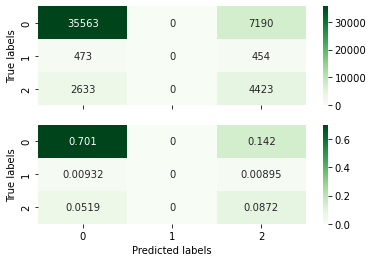

In [229]:
lgbm_nf = lightgbm.LGBMClassifier(objective='multiclass',
                                    is_unbalance = True,
                                    num_classes = 3,
                                    **study.best_params)
lgbm_nf.fit(X_res, Y_res)
Y_preds = lgbm_nf.predict(X_test)
custom_logging(Y_test, Y_preds)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


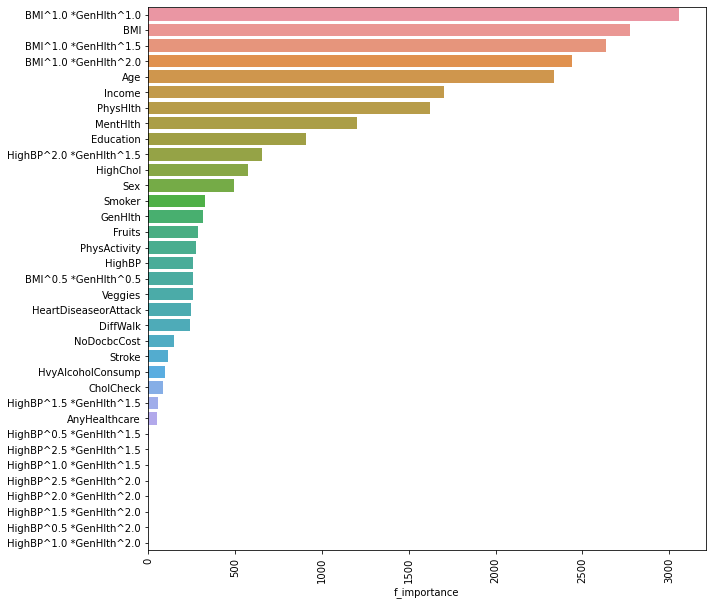

In [129]:
plt.figure(figsize = (10,10))
sns.barplot(feature_importances.f_importance,  feature_importances.index, orient = 'h')
plt.xticks(rotation = 90)
plt.show()

#### RF hyperparameter search w/ RandomizedSearchCV

In [29]:
from sklearn.model_selection import RandomizedSearchCV


In [30]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [52]:
n_estimators = np.arange(100, 2000, 100)
max_depth = np.append(np.arange(2,34,2), None)
min_samples_split = np.arange(2, 12,2)
min_samples_leaf = [1, 2, 4, 6, 8]
bootstrap = [True, False]
max_features = ['auto', 'sqrt', 'log2']
criterion = ['gini', 'entropy']

In [53]:
param_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'max_features':max_features,
    'criterion':criterion

}

In [54]:
param_grid

{'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
        1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
 'max_depth': array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, None],
       dtype=object),
 'min_samples_split': array([ 2,  4,  6,  8, 10]),
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['gini', 'entropy']}

In [34]:
rf_model = RandomForestClassifier(n_jobs=-1)
search = RandomizedSearchCV(estimator=rf_model,
                            n_iter=1, 
                            param_distributions = param_grid,
                            cv = 10, verbose = 1, scoring = 'balanced_accuracy', 
                            random_state = 25)

search.fit(X_res, Y_res)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1), n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, None],
      dtype=object),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
       1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700,
       1750, 1800, 1850, 1900, 1950])},
        

In [35]:
search.best_params_

{'n_estimators': 1900,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 22,
 'criterion': 'gini',
 'bootstrap': True}

              precision    recall  f1-score   support

           0       0.92      0.82      0.87     42753
           1       0.00      0.00      0.00       927
           2       0.36      0.63      0.46      7056

    accuracy                           0.78     50736
   macro avg       0.43      0.49      0.44     50736
weighted avg       0.82      0.78      0.80     50736


ACC: 	0.782481866918953
MCC: 	0.35330415361798
Confusion matrix: 


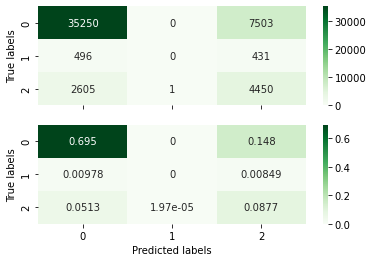

In [51]:
rf_model = RandomForestClassifier(n_jobs = -1, n_estimators= 1900,
    min_samples_split= 10,
    min_samples_leaf= 2,
    max_features ='sqrt',
    max_depth= 22,
    criterion= 'gini',
    bootstrap= True)
rf_model.fit(X_res, Y_res)
Y_preds = rf_model.predict(X_test)
custom_logging(Y_test, Y_preds)

In [56]:
rf_model = RandomForestClassifier(n_jobs=-1)
search = RandomizedSearchCV(estimator=rf_model,
                            n_iter=10, 
                            param_distributions = param_grid,
                            cv = 10, verbose = 3, scoring = 'balanced_accuracy', 
                            random_state = 25)

search.fit(X_res, Y_res)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END bootstrap=True, criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1800;, score=0.494 total time=  13.6s
[CV 2/10] END bootstrap=True, criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1800;, score=0.483 total time=   9.8s
[CV 3/10] END bootstrap=True, criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1800;, score=0.494 total time=   9.9s
[CV 4/10] END bootstrap=True, criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1800;, score=0.492 total time=   9.9s
[CV 5/10] END bootstrap=True, criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1800;, score=0.484 total time=   9.9s
[CV 6/10] END bootstrap=True, criterion=entropy, max_depth=8, max_f

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, None],
      dtype=object),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])},
                   random_state=25, scoring='balanced_accuracy', verbose=3)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.64      0.47      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7871136865342163
MCC: 	0.36610465760248173
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


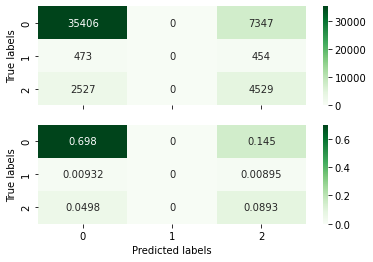

In [59]:
Y_preds = search.best_estimator_.predict(X_test)
custom_logging(Y_test, Y_preds)

#### XGB hyperparam tuning - stalled, as it has been outperformed by rf and lgbm and the search was running to long

In [69]:
xgb_params = dict(
                eta = np.linspace(0.01, 0.3,20),            # learning rate
                gamma = np.linspace(0, 5,5),              # minimum loss reduction to make a split
                max_depth = np.arange(4,14,2),           # default 6
                min_child_weight = np.arange(0, 12, 2),
                max_delta_step = np.arange(0, 10, 2),    # can help w/ imbalanced data
                subsample = np.arange(.5,1,.1)
                )

In [71]:
xgb_params

{'eta': array([0.01      , 0.02526316, 0.04052632, 0.05578947, 0.07105263,
        0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842,
        0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421,
        0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3       ]),
 'gamma': array([0.  , 1.25, 2.5 , 3.75, 5.  ]),
 'max_depth': array([ 4,  6,  8, 10, 12]),
 'min_child_weight': array([ 0,  2,  4,  6,  8, 10]),
 'max_delta_step': array([0, 2, 4, 6, 8]),
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}

In [ ]:
xgb_model = xgboost.XGBClassifier(
                                objective='multi:softmax',
                                tree_method = 'gpu_hist')

search = RandomizedSearchCV(estimator=xgb_model,
                            n_iter=100, 
                            param_distributions = xgb_params,
                            cv = 10, verbose = 3, scoring = 'balanced_accuracy', 
                            random_state = 25)

search.fit(X_res, Y_res)

In [74]:
search.best_params_

{'subsample': 0.7999999999999999,
 'min_child_weight': 0,
 'max_depth': 6,
 'max_delta_step': 8,
 'gamma': 1.25,
 'eta': 0.0863157894736842}

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     42753
           1       0.00      0.00      0.00       927
           2       0.37      0.65      0.47      7056

    accuracy                           0.79     50736
   macro avg       0.43      0.49      0.45     50736
weighted avg       0.83      0.79      0.80     50736


ACC: 	0.7877838221381268
MCC: 	0.3717785675334783
Confusion matrix: 


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


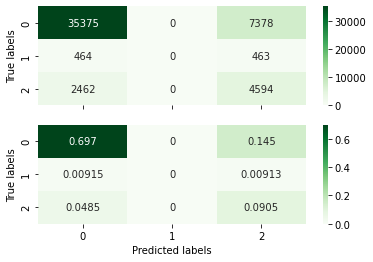

In [75]:
Y_preds = search.best_estimator_.predict(X_test)
custom_logging(Y_test, Y_preds)

In [77]:
search.best_estimator_.best_iteration

99

In [79]:
xgb_params = dict(
                n_estimators = np.arange(100, 2500, 100),
                eta = np.linspace(0.01, 0.3,20),            # learning rate
                gamma = np.linspace(0, 5,5),              # minimum loss reduction to make a split
                max_depth = np.arange(4,14,2),           # default 6
                min_child_weight = np.arange(0, 12, 2),
                max_delta_step = np.arange(0, 10, 2),    # can help w/ imbalanced data
                subsample = np.arange(.5,1,.1)
                )

In [80]:
xgb_params

{'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
        1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
        2300, 2400]),
 'eta': array([0.01      , 0.02526316, 0.04052632, 0.05578947, 0.07105263,
        0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842,
        0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421,
        0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3       ]),
 'gamma': array([0.  , 1.25, 2.5 , 3.75, 5.  ]),
 'max_depth': array([ 4,  6,  8, 10, 12]),
 'min_child_weight': array([ 0,  2,  4,  6,  8, 10]),
 'max_delta_step': array([0, 2, 4, 6, 8]),
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}

In [81]:
xgb_model = xgboost.XGBClassifier(
                                objective='multi:softmax',
                                tree_method = 'gpu_hist')

search = RandomizedSearchCV(estimator = xgb_model,
                            n_iter = 100, 
                            param_distributions = xgb_params,
                            cv = 10, verbose = 3, scoring = 'balanced_accuracy', 
                            random_state = 25)

search.fit(X_res, Y_res)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[04:15:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.498 total time=  11.6s
[04:16:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.491 total time=  12.7s
[04:16:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.500 total time=  12.6s
[04:16:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.497 total time=  12.5s
[04:16:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.488 total time=  12.7s
[04:16:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.490 total time=  12.5s
[04:17:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.489 total time=  12.8s
[04:17:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.492 total time=  12.6s
[04:17:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.483 total time=  12.8s
[04:17:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.01, gamma=1.25, max_delta_step=6, max_depth=6, min_child_weight=4, n_estimators=1400, subsample=0.7999999999999999;, score=0.491 total time=  11.9s
[04:17:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.498 total time=   3.0s
[04:17:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.489 total time=   3.1s
[04:18:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.499 total time=   3.6s
[04:18:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.497 total time=   3.6s
[04:18:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.489 total time=   3.6s
[04:18:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.490 total time=   3.6s
[04:18:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.489 total time=   3.6s
[04:18:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.491 total time=   3.6s
[04:18:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.484 total time=   3.6s
[04:18:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.1931578947368421, gamma=3.75, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1800, subsample=0.6;, score=0.491 total time=   3.6s
[04:18:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.498 total time=   1.5s
[04:18:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.492 total time=   1.5s
[04:18:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.499 total time=   1.5s
[04:18:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.497 total time=   1.5s
[04:18:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.490 total time=   1.5s
[04:18:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.490 total time=   1.5s
[04:18:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.487 total time=   1.5s
[04:18:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.489 total time=   1.5s
[04:18:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.484 total time=   1.5s
[04:18:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.17789473684210527, gamma=3.75, max_delta_step=6, max_depth=4, min_child_weight=6, n_estimators=700, subsample=0.8999999999999999;, score=0.491 total time=   1.5s
[04:18:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.497 total time=   1.7s
[04:18:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.491 total time=   1.7s
[04:18:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.499 total time=   1.7s
[04:18:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.497 total time=   1.7s
[04:18:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.489 total time=   1.7s
[04:18:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.489 total time=   1.7s
[04:18:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.488 total time=   1.7s
[04:18:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.491 total time=   1.7s
[04:19:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.484 total time=   1.7s
[04:19:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.10157894736842105, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.6;, score=0.491 total time=   1.7s
[04:19:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.497 total time=   4.6s
[04:19:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.492 total time=   4.7s
[04:19:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.501 total time=   4.7s
[04:19:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.498 total time=   4.6s
[04:19:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.489 total time=   4.7s
[04:19:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.491 total time=   4.6s
[04:19:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.489 total time=   4.7s
[04:19:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.492 total time=   4.7s
[04:19:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.484 total time=   4.6s
[04:19:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.02526315789473684, gamma=2.5, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1000, subsample=0.5;, score=0.492 total time=   4.7s
[04:19:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.495 total time=   3.6s
[04:19:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.486 total time=   3.6s
[04:19:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.494 total time=   3.6s
[04:20:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.492 total time=   3.6s
[04:20:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.484 total time=   3.6s
[04:20:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.489 total time=   3.5s
[04:20:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.487 total time=   3.6s
[04:20:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.487 total time=   3.6s
[04:20:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.480 total time=   3.6s
[04:20:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.1473684210526316, gamma=0.0, max_delta_step=6, max_depth=6, min_child_weight=10, n_estimators=300, subsample=0.8999999999999999;, score=0.486 total time=   3.6s
[04:20:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.495 total time=   2.3s
[04:20:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.483 total time=   2.4s
[04:20:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.494 total time=   2.4s
[04:20:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.490 total time=   2.4s
[04:20:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.481 total time=   2.4s
[04:20:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.486 total time=   2.3s
[04:20:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.482 total time=   2.3s
[04:20:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.487 total time=   2.3s
[04:20:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.474 total time=   2.4s
[04:20:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7;, score=0.484 total time=   2.4s
[04:20:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.497 total time=   1.6s
[04:20:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.492 total time=   1.6s
[04:20:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.499 total time=   1.6s
[04:20:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.497 total time=   1.6s
[04:20:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.488 total time=   1.6s
[04:20:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.491 total time=   1.6s
[04:20:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.488 total time=   1.6s
[04:21:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.491 total time=   1.6s
[04:21:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.483 total time=   1.6s
[04:21:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.11684210526315789, gamma=3.75, max_delta_step=2, max_depth=8, min_child_weight=4, n_estimators=500, subsample=0.7999999999999999;, score=0.490 total time=   1.6s
[04:21:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.498 total time=   1.1s
[04:21:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.491 total time=   1.0s
[04:21:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.498 total time=   1.0s
[04:21:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.496 total time=   1.0s
[04:21:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.489 total time=   1.0s
[04:21:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.489 total time=   1.0s
[04:21:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.487 total time=   1.0s
[04:21:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.491 total time=   1.0s
[04:21:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.485 total time=   1.1s
[04:21:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.16263157894736843, gamma=5.0, max_delta_step=2, max_depth=6, min_child_weight=8, n_estimators=400, subsample=0.7999999999999999;, score=0.491 total time=   1.0s
[04:21:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.497 total time=   3.3s
[04:21:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.490 total time=   3.3s
[04:21:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.498 total time=   3.3s
[04:21:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.498 total time=   3.3s
[04:21:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.488 total time=   3.3s
[04:21:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.490 total time=   3.3s
[04:21:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.488 total time=   3.3s
[04:21:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.492 total time=   3.3s
[04:21:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.483 total time=   3.2s
[04:21:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.13210526315789473, gamma=5.0, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=1600, subsample=0.7;, score=0.490 total time=   3.3s
[04:21:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.498 total time=   0.8s
[04:21:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.490 total time=   0.8s
[04:21:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.500 total time=   0.8s
[04:21:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.498 total time=   0.8s
[04:21:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.484 total time=   0.8s
[04:21:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.490 total time=   0.8s
[04:21:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.488 total time=   0.8s
[04:21:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.490 total time=   0.8s
[04:21:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.483 total time=   0.8s
[04:21:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=8, max_depth=8, min_child_weight=8, n_estimators=200, subsample=0.7999999999999999;, score=0.490 total time=   0.8s
[04:21:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.472 total time=  17.1s
[04:22:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.466 total time=  16.2s
[04:22:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.473 total time=  16.3s
[04:22:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.472 total time=  16.3s
[04:23:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.461 total time=  16.4s
[04:23:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.459 total time=  16.2s
[04:23:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.461 total time=  16.3s
[04:23:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.464 total time=  16.2s
[04:24:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.460 total time=  16.2s
[04:24:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.3, gamma=0.0, max_delta_step=0, max_depth=6, min_child_weight=8, n_estimators=1300, subsample=0.5;, score=0.463 total time=  16.2s
[04:24:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.496 total time=   2.1s
[04:24:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.490 total time=   2.1s
[04:24:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.500 total time=   2.1s
[04:24:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.495 total time=   2.1s
[04:24:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.488 total time=   2.1s
[04:24:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.490 total time=   2.1s
[04:24:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.488 total time=   2.1s
[04:24:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.492 total time=   2.1s
[04:24:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.483 total time=   2.1s
[04:24:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.2236842105263158, gamma=2.5, max_delta_step=4, max_depth=6, min_child_weight=8, n_estimators=1100, subsample=0.7;, score=0.490 total time=   2.1s
[04:25:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.497 total time=   3.8s
[04:25:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.488 total time=   3.8s
[04:25:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.500 total time=   3.9s
[04:25:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.494 total time=   3.8s
[04:25:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.487 total time=   4.0s
[04:25:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.490 total time=   4.1s
[04:25:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.487 total time=   4.0s
[04:25:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.489 total time=   4.1s
[04:25:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.483 total time=   4.1s
[04:25:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.0863157894736842, gamma=1.25, max_delta_step=4, max_depth=8, min_child_weight=6, n_estimators=400, subsample=0.7;, score=0.491 total time=   4.1s
[04:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.498 total time=   3.1s
[04:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.489 total time=   3.1s
[04:25:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.499 total time=   3.1s
[04:25:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.496 total time=   3.1s
[04:25:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.488 total time=   3.1s
[04:25:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.489 total time=   3.1s
[04:25:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.488 total time=   3.1s
[04:26:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.491 total time=   3.1s
[04:26:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.484 total time=   3.1s
[04:26:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.2847368421052632, gamma=2.5, max_delta_step=0, max_depth=8, min_child_weight=10, n_estimators=1400, subsample=0.8999999999999999;, score=0.489 total time=   3.1s
[04:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.498 total time=   3.5s
[04:26:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.491 total time=   3.5s
[04:26:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.500 total time=   3.5s
[04:26:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.497 total time=   3.5s
[04:26:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.488 total time=   3.6s
[04:26:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.491 total time=   3.5s
[04:26:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.488 total time=   3.5s
[04:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.492 total time=   3.5s
[04:26:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.484 total time=   3.5s
[04:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.05578947368421053, gamma=3.75, max_delta_step=2, max_depth=12, min_child_weight=2, n_estimators=1200, subsample=0.5;, score=0.491 total time=   3.5s
[04:26:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.498 total time=   1.4s
[04:26:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.491 total time=   1.4s
[04:26:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.500 total time=   1.4s
[04:26:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.497 total time=   1.4s
[04:26:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.487 total time=   1.4s
[04:26:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.489 total time=   1.4s
[04:26:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.488 total time=   1.4s
[04:26:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.491 total time=   1.4s
[04:26:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.484 total time=   1.4s
[04:26:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=100, subsample=0.8999999999999999;, score=0.491 total time=   1.4s
[04:27:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.474 total time=  15.3s
[04:27:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.467 total time=  15.1s
[04:27:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.470 total time=  15.4s
[04:27:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.470 total time=  15.0s
[04:28:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.465 total time=  15.4s
[04:28:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.464 total time=  15.5s
[04:28:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.463 total time=  15.3s
[04:28:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.462 total time=  15.4s
[04:29:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.459 total time=  15.3s
[04:29:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.2847368421052632, gamma=0.0, max_delta_step=8, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.5;, score=0.466 total time=  15.3s
[04:29:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.497 total time=   9.1s
[04:29:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.490 total time=   9.1s
[04:29:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.499 total time=   9.1s
[04:30:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.496 total time=   9.1s
[04:30:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.488 total time=   9.1s
[04:30:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.489 total time=   9.1s
[04:30:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.488 total time=   9.1s
[04:30:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.491 total time=   9.1s
[04:30:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.483 total time=   9.1s
[04:30:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=8, max_depth=4, min_child_weight=10, n_estimators=1800, subsample=0.8999999999999999;, score=0.490 total time=   9.1s
[04:31:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.495 total time=  17.5s
[04:31:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.487 total time=  17.5s
[04:31:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.499 total time=  17.6s
[04:31:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.494 total time=  16.5s
[04:32:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.486 total time=  16.4s
[04:32:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.490 total time=  17.4s
[04:32:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.486 total time=  17.6s
[04:33:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.490 total time=  17.4s
[04:33:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.483 total time=  17.5s
[04:33:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.02526315789473684, gamma=0.0, max_delta_step=2, max_depth=6, min_child_weight=0, n_estimators=1200, subsample=0.5;, score=0.490 total time=  17.5s
[04:33:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.490 total time=   5.9s
[04:34:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.480 total time=   5.9s
[04:34:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.490 total time=   6.0s
[04:34:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.489 total time=   5.9s
[04:34:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.482 total time=   5.9s
[04:34:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.484 total time=   5.9s
[04:34:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.483 total time=   5.9s
[04:34:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.482 total time=   6.0s
[04:34:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.477 total time=   6.0s
[04:34:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.16263157894736843, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=8, n_estimators=800, subsample=0.5;, score=0.483 total time=   5.9s
[04:34:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.496 total time=   4.4s
[04:35:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.491 total time=   4.4s
[04:35:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.498 total time=   4.4s
[04:35:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.496 total time=   4.4s
[04:35:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.487 total time=   4.4s
[04:35:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.490 total time=   4.4s
[04:35:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.489 total time=   4.4s
[04:35:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.490 total time=   4.4s
[04:35:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.485 total time=   4.4s
[04:35:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.17789473684210527, gamma=5.0, max_delta_step=0, max_depth=8, min_child_weight=8, n_estimators=2100, subsample=0.8999999999999999;, score=0.490 total time=   4.4s
[04:35:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.496 total time=   3.2s
[04:35:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.490 total time=   3.3s
[04:35:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.499 total time=   3.3s
[04:35:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.496 total time=   3.3s
[04:35:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.489 total time=   3.3s
[04:35:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.490 total time=   3.3s
[04:36:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.486 total time=   3.2s
[04:36:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.491 total time=   3.2s
[04:36:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.483 total time=   3.3s
[04:36:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.13210526315789473, gamma=1.25, max_delta_step=8, max_depth=4, min_child_weight=2, n_estimators=1000, subsample=0.7;, score=0.490 total time=   3.3s
[04:36:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.481 total time=  12.1s
[04:36:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.475 total time=  12.1s
[04:36:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.483 total time=  12.2s
[04:36:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.477 total time=  12.0s
[04:37:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.473 total time=  12.2s
[04:37:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.474 total time=  12.1s
[04:37:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.473 total time=  12.0s
[04:37:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.473 total time=  12.2s
[04:37:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.467 total time=  12.2s
[04:38:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.1931578947368421, gamma=0.0, max_delta_step=4, max_depth=8, min_child_weight=2, n_estimators=300, subsample=0.6;, score=0.474 total time=  12.2s
[04:38:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.498 total time=   1.5s
[04:38:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.490 total time=   1.5s
[04:38:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.498 total time=   1.5s
[04:38:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.495 total time=   1.5s
[04:38:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.488 total time=   1.5s
[04:38:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.490 total time=   1.5s
[04:38:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.489 total time=   1.5s
[04:38:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.491 total time=   1.5s
[04:38:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.485 total time=   1.5s
[04:38:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.1473684210526316, gamma=3.75, max_delta_step=0, max_depth=6, min_child_weight=6, n_estimators=600, subsample=0.7999999999999999;, score=0.491 total time=   1.5s
[04:38:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.494 total time=  12.1s
[04:38:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.486 total time=  11.3s
[04:38:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.494 total time=  11.3s
[04:39:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.493 total time=  11.2s
[04:39:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.483 total time=  11.4s
[04:39:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.486 total time=  11.2s
[04:39:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.486 total time=  11.4s
[04:39:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.486 total time=  11.4s
[04:40:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.482 total time=  11.3s
[04:40:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.05578947368421053, gamma=1.25, max_delta_step=2, max_depth=6, min_child_weight=10, n_estimators=1600, subsample=0.5;, score=0.487 total time=  11.3s
[04:40:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.496 total time=   1.9s
[04:40:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.487 total time=   1.9s
[04:40:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.499 total time=   1.9s
[04:40:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.495 total time=   2.2s
[04:40:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.484 total time=   2.2s
[04:40:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.489 total time=   2.2s
[04:40:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.488 total time=   2.2s
[04:40:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 8/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.491 total time=   2.1s
[04:40:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 9/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.482 total time=   2.2s
[04:40:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 10/10] END eta=0.2694736842105263, gamma=1.25, max_delta_step=8, max_depth=6, min_child_weight=4, n_estimators=700, subsample=0.7999999999999999;, score=0.487 total time=   2.2s


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:40:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/10] END eta=0.01, gamma=0.0, max_delta_step=2, max_depth=12, min_child_weight=0, n_estimators=1500, subsample=0.5;, score=0.484 total time= 7.8min


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:48:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/10] END eta=0.01, gamma=0.0, max_delta_step=2, max_depth=12, min_child_weight=0, n_estimators=1500, subsample=0.5;, score=0.481 total time= 7.8min


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:56:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/10] END eta=0.01, gamma=0.0, max_delta_step=2, max_depth=12, min_child_weight=0, n_estimators=1500, subsample=0.5;, score=0.485 total time= 7.6min


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:03:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/10] END eta=0.01, gamma=0.0, max_delta_step=2, max_depth=12, min_child_weight=0, n_estimators=1500, subsample=0.5;, score=0.481 total time= 7.4min


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:11:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/10] END eta=0.01, gamma=0.0, max_delta_step=2, max_depth=12, min_child_weight=0, n_estimators=1500, subsample=0.5;, score=0.477 total time= 7.8min


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:19:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 6/10] END eta=0.01, gamma=0.0, max_delta_step=2, max_depth=12, min_child_weight=0, n_estimators=1500, subsample=0.5;, score=0.477 total time= 7.7min


/home/hdd_n/mambaforge/envs/exp/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:26:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Voting Classifier

In [18]:
# base features
RF = RandomForestClassifier(n_estimators=450,
                            min_samples_split=2,
                            min_samples_leaf=6, 
                            max_features='log2',
                            max_depth=16, 
                            bootstrap=True, njobs = -1)

XGB = xgboost.XGBClassifier(objective = 'multi:softmax', num_classes = 3)
LGBM = lightgbm.LGBMClassifier(objective = 'multiclass', num_classes = 3)

voting_classifier = VotingClassifier( estimators = [
    ('RF', RF),
    ('XGB', XGB),
    ('LGBM', LGBM)
], voting = 'hard')

In [19]:
with mlflow.start_run(run_name = "Voting clasifier_1", experiment_id = 1) as run:
    voting_classifier.fit(X_train, Y_train)
    Y_preds = voting_classifier.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/11 15:32:30 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('RF', RandomForestClassifier(max_depth=16, max_features='log2', min_samples_leaf=6,
                       n_estimators=450)), ('XGB', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, cols...`
2022/01/11 15:32:30 WARNING mlflow.utils: Truncated the value of the key `XGB`. Truncated value: `XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_const...`
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[15:33:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:33:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/01/11 15:38:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.17      0.26      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28344765058341215
MSE: 	0.5486242510249133
ACC: 	0.8491406496373384
MCC: 	0.24400207827775405


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [10]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

for col in X_train.columns:
  X_train[col] = mm_scaler.fit_transform(X_train[[col]])

for col in X_test.columns:
  X_test[col] = mm_scaler.fit_transform(X_test[[col]])

In [11]:
from sklearn import svm
clf = svm.SVC(C=0.1, kernel = 'poly', gamma = 0.2, degree = 3, class_weight='balanced')

clf.fit(X_train, Y_train)
prediction = clf.predict(X_test)

In [16]:
from joblib import dump, load


In [18]:
dump(clf, 'models/tuned_svm.joblib')

['models/tuned_svm.joblib']

In [12]:
X_train

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
136803,0.0,0.0,1.0,0.209302,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.416667,0.8,1.000000
24415,1.0,0.0,1.0,0.313953,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.333333,0.033333,0.0,0.0,0.416667,1.0,1.000000
153628,0.0,0.0,1.0,0.232558,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.000000,1.0,0.857143
135892,0.0,0.0,1.0,0.174419,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.25,0.000000,0.066667,0.0,0.0,0.666667,0.6,0.428571
73520,1.0,1.0,1.0,0.197674,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,1.0,0.0,0.916667,0.6,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220060,0.0,0.0,1.0,0.093023,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.50,0.033333,0.133333,0.0,0.0,0.083333,1.0,0.857143
23775,1.0,0.0,1.0,0.244186,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.666667,0.6,0.571429
37135,0.0,1.0,1.0,0.139535,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,0.833333,1.0,1.000000
92634,0.0,0.0,1.0,0.162791,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.500000,0.6,0.714286


              precision    recall  f1-score   support

           0       0.96      0.63      0.76     42753
           1       0.03      0.31      0.05       927
           2       0.34      0.60      0.43      7056

    accuracy                           0.62     50736
   macro avg       0.44      0.51      0.41     50736
weighted avg       0.85      0.62      0.70     50736


ACC: 	0.6174116997792495
MCC: 	0.28403354711330375
Confusion matrix: 


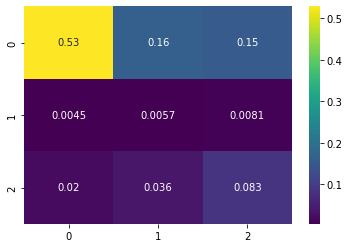

In [15]:
custom_logging(Y_test, prediction)

In [32]:
X_train

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
136803,0.0,0.0,1.0,0.209302,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.416667,0.8,1.000000
24415,1.0,0.0,1.0,0.313953,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.333333,0.033333,0.0,0.0,0.416667,1.0,1.000000
153628,0.0,0.0,1.0,0.232558,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.000000,1.0,0.857143
135892,0.0,0.0,1.0,0.174419,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.25,0.000000,0.066667,0.0,0.0,0.666667,0.6,0.428571
73520,1.0,1.0,1.0,0.197674,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,1.0,0.0,0.916667,0.6,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220060,0.0,0.0,1.0,0.093023,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.50,0.033333,0.133333,0.0,0.0,0.083333,1.0,0.857143
23775,1.0,0.0,1.0,0.244186,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.666667,0.6,0.571429
37135,0.0,1.0,1.0,0.139535,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,0.833333,1.0,1.000000
92634,0.0,0.0,1.0,0.162791,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.500000,0.6,0.714286


In [33]:
kNN = KNeighborsClassifier(n_neighbors=3) 
kNN.fit(X_train, Y_train) 
Y_pred = kNN.predict(X_test) 
custom_logging(Y_test, Y_pred)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     42753
           1       0.03      0.00      0.00       927
           2       0.36      0.23      0.28      7056

    accuracy                           0.82     50736
   macro avg       0.42      0.39      0.39     50736
weighted avg       0.78      0.82      0.80     50736

MAE: 	0.34417376222011986
MSE: 	0.668677073478398
ACC: 	0.8180778934090193
MCC: 	0.1923243886223946


In [34]:
X_train

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
136803,0.0,0.0,1.0,0.209302,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.416667,0.8,1.000000
24415,1.0,0.0,1.0,0.313953,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.333333,0.033333,0.0,0.0,0.416667,1.0,1.000000
153628,0.0,0.0,1.0,0.232558,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.000000,1.0,0.857143
135892,0.0,0.0,1.0,0.174419,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.25,0.000000,0.066667,0.0,0.0,0.666667,0.6,0.428571
73520,1.0,1.0,1.0,0.197674,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,1.0,0.0,0.916667,0.6,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220060,0.0,0.0,1.0,0.093023,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.50,0.033333,0.133333,0.0,0.0,0.083333,1.0,0.857143
23775,1.0,0.0,1.0,0.244186,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.666667,0.6,0.571429
37135,0.0,1.0,1.0,0.139535,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,0.833333,1.0,1.000000
92634,0.0,0.0,1.0,0.162791,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,1.0,0.500000,0.6,0.714286


In [37]:
mlflow.end_run()

In [38]:
# base scaled features 
RF = RandomForestClassifier(n_estimators=450,
                            min_samples_split=2,
                            min_samples_leaf=6, 
                            max_features='log2',
                            max_depth=16, 
                            bootstrap=True, n_jobs = -1)

XGB = xgboost.XGBClassifier(objective = 'multi:softmax', num_classes = 3)
LGBM = lightgbm.LGBMClassifier(objective = 'multiclass', num_classes = 3)

voting_classifier = VotingClassifier( estimators = [
    ('RF', RF),
    ('XGB', XGB),
    ('LGBM', LGBM)
], voting = 'hard')

with mlflow.start_run(run_name = "Voting clasifier_2_scaled_features", experiment_id = 1) as run:
    voting_classifier.fit(X_train, Y_train)
    Y_preds = voting_classifier.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/11 16:44:36 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('RF', RandomForestClassifier(max_depth=16, max_features='log2', min_samples_leaf=6,
                       n_estimators=450, n_jobs=-1)), ('XGB', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode...`
2022/01/11 16:44:36 WARNING mlflow.utils: Truncated the value of the key `XGB`. Truncated value: `XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_const...`
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[16:44:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:44:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/01/11 16:54:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.17      0.26      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28344765058341215
MSE: 	0.5486242510249133
ACC: 	0.8491406496373384
MCC: 	0.24372732808014347


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [40]:
#
RF = RandomForestClassifier(n_estimators=450,
                            min_samples_split=2,
                            min_samples_leaf=6, 
                            max_features='log2',
                            max_depth=16, 
                            bootstrap=True, n_jobs = -1)

XGB = xgboost.XGBClassifier(objective = 'multi:softmax', num_classes = 3)
LGBM = lightgbm.LGBMClassifier(objective = 'multiclass', num_classes = 3)
KNN = KNeighborsClassifier(n_neighbors=3)
SVM = svm.SVC(C=0.1, kernel = 'poly', gamma = 0.2, degree = 3, class_weight='balanced')
voting_classifier_2 = VotingClassifier( estimators = [
    ('RF', RF),
    ('XGB', XGB),
    ('LGBM', LGBM),
    ('KNN', KNN),
    ('SVM', SVM)
], voting = 'hard')

with mlflow.start_run(run_name = "Voting clasifier_3_scaled_features", experiment_id = 1) as run:
    voting_classifier_2.fit(X_train, Y_train)
    Y_preds = voting_classifier_2.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/11 16:56:45 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('RF', RandomForestClassifier(max_depth=16, max_features='log2', min_samples_leaf=6,
                       n_estimators=450, n_jobs=-1)), ('XGB', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode...`
2022/01/11 16:56:45 WARNING mlflow.utils: Truncated the value of the key `XGB`. Truncated value: `XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_const...`
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

[16:57:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:57:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022/01/11 17:09:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.58      0.15      0.23      7056

    accuracy                           0.85     50736
   macro avg       0.48      0.38      0.38     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.2831717123935667
MSE: 	0.5480723746452223
ACC: 	0.8492786187322611
MCC: 	0.23155969758407152


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [42]:
# Removed XGB
RF = RandomForestClassifier(n_estimators=450,
                            min_samples_split=2,
                            min_samples_leaf=6, 
                            max_features='log2',
                            max_depth=16, 
                            bootstrap=True, n_jobs = -1)

LGBM = lightgbm.LGBMClassifier(objective = 'multiclass', num_classes = 3)
KNN = KNeighborsClassifier(n_neighbors=3)
SVM = svm.SVC(C=0.1, kernel = 'poly', gamma = 0.2, degree = 3, class_weight='balanced')



with mlflow.start_run(run_name = "Voting clasifier_4_scaled_features", experiment_id = 1) as run:
    voting_classifier_3 = VotingClassifier( estimators = [
        ('RF', RF),
        ('LGBM', LGBM),
        ('KNN', KNN),
        ('SVM', SVM)
    ], voting = 'hard')
    voting_classifier_3.fit(X_train, Y_train)
    Y_preds = voting_classifier_3.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/11 17:14:30 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('RF', RandomForestClassifier(max_depth=16, max_features='log2', min_samples_leaf=6,
                       n_estimators=450, n_jobs=-1)), ('LGBM', LGBMClassifier(num_classes=3, objective='multiclass')), ('KNN', KNeighborsClassifier(n_neighbors=3...`
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/01/11 17:21:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is depreca

              precision    recall  f1-score   support

           0       0.85      0.99      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.59      0.08      0.14      7056

    accuracy                           0.85     50736
   macro avg       0.48      0.36      0.35     50736
weighted avg       0.80      0.85      0.79     50736

MAE: 	0.2885327972248502
MSE: 	0.5587945443077893
ACC: 	0.8465980763166193
MCC: 	0.1728628294395301


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo